In [1]:
!pip install ndjson


In [2]:
PATH = "/content/review_corpus_en.ndjson"

In [3]:
import ndjson
from sklearn.model_selection import train_test_split

with open(PATH) as i:
    data = ndjson.load(i)

texts = [" ".join([doc["title"], doc["body"]]) for doc in data]
labels = [doc["rating"] for doc in data]

rest_texts, test_texts, rest_labels, test_labels = train_test_split(texts, labels, test_size=0.1, random_state=1)
train_texts, dev_texts, train_labels, dev_labels = train_test_split(rest_texts, rest_labels, test_size=0.1, random_state=1)

print("Train size:", len(train_texts))
print("Dev size:", len(dev_texts))
print("Test size:", len(test_texts))

Train size: 2430
Dev size: 270
Test size: 300


In [4]:
target_names = list(set(labels))
label2idx = {label: idx for idx, label in enumerate(target_names)}
print(label2idx)

{'mixed': 0, 'pos': 1, 'neg': 2}


In [5]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(multi_class="ovr", solver="lbfgs"))
])

parameters = {'lr__C': [0.1, 0.5, 1, 2, 5, 10, 100, 1000]}

best_classifier = GridSearchCV(pipeline, parameters, cv=5, verbose=1)
best_classifier.fit(train_texts, train_labels)
best_predictions = best_classifier.predict(test_texts)

baseline_accuracy = np.mean(best_predictions == test_labels)
print("Baseline accuracy:", baseline_accuracy)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Baseline accuracy: 0.6266666666666667


In [6]:
!pip install transformers

In [7]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
BERT_MODEL = "bert-base-uncased"

In [9]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [10]:
from transformers import BertForSequenceClassification


In [11]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label2idx))
model.to(device)  # Assuming 'device' is defined, like device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [12]:
pip install transformers --upgrade


In [13]:
import logging
import numpy as np

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

MAX_SEQ_LENGTH=100

class BertInputItem(object):
    """An item with all the necessary attributes for finetuning BERT."""

    def __init__(self, text, input_ids, input_mask, segment_ids, label_id):
        self.text = text
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id


def convert_examples_to_inputs(example_texts, example_labels, label2idx, max_seq_length, tokenizer, verbose=0):
    """Loads a data file into a list of `InputBatch`s."""

    input_items = []
    examples = zip(example_texts, example_labels)
    for (ex_index, (text, label)) in enumerate(examples):

        # Create a list of token ids
        input_ids = tokenizer.encode(f"[CLS] {text} [SEP]")
        if len(input_ids) > max_seq_length:
            input_ids = input_ids[:max_seq_length]

        # All our tokens are in the first input segment (id 0).
        segment_ids = [0] * len(input_ids)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label2idx[label]

        input_items.append(
            BertInputItem(text=text,
                          input_ids=input_ids,
                          input_mask=input_mask,
                          segment_ids=segment_ids,
                          label_id=label_id))


    return input_items

train_features = convert_examples_to_inputs(train_texts, train_labels, label2idx, MAX_SEQ_LENGTH, tokenizer, verbose=0)
dev_features = convert_examples_to_inputs(dev_texts, dev_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)
test_features = convert_examples_to_inputs(test_texts, test_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)

Token indices sequence length is longer than the specified maximum sequence length for this model (534 > 512). Running this sequence through the model will result in indexing errors


In [14]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

def get_data_loader(features, max_seq_length, batch_size, shuffle=True):

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    return dataloader

BATCH_SIZE = 16

train_dataloader = get_data_loader(train_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=True)
dev_dataloader = get_data_loader(dev_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)
test_dataloader = get_data_loader(test_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)

In [15]:
def evaluate(model, dataloader):
    model.eval()

    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []

    for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            tmp_eval_loss, logits = model(input_ids, attention_mask=input_mask,
                                          token_type_ids=segment_ids, labels=label_ids)

        outputs = np.argmax(logits.to('cpu'), axis=1)
        label_ids = label_ids.to('cpu').numpy()

        predicted_labels += list(outputs)
        correct_labels += list(label_ids)

        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps

    correct_labels = np.array(correct_labels)
    predicted_labels = np.array(predicted_labels)

    return eval_loss, correct_labels, predicted_labels

In [16]:
LEARNING_RATE = 5e-5  # This is a common learning rate for BERT models.


In [17]:
WARMUP_STEPS = 1000  # Example value; adjust based on your training regime
TOTAL_TRAIN_STEPS = 20000  # Example value; calculate as num_epochs * (num_samples / batch_size)


In [18]:
from transformers import AdamW, get_linear_schedule_with_warmup

# Usage within a training loop
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=TOTAL_TRAIN_STEPS)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:
NUM_TRAIN_EPOCHS = 20  # You can adjust this number based on your specific needs

from tqdm import trange  # Ensure tqdm is imported if you're using trange for progress bar

loss_history = []
no_improvement = 0
for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    model.train()
    tr_loss = 0
    # Continue with your training loop


Epoch: 100%|██████████| 20/20 [00:00<00:00, 1094.56it/s]


In [20]:
GRADIENT_ACCUMULATION_STEPS = 1  # Or any other appropriate value depending on your system's capability and batch size

# Then continue with your training loop
loss_history = []
no_improvement = 0
for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    model.train()
    tr_loss = 0
    # rest of your training code


Epoch: 100%|██████████| 20/20 [00:00<00:00, 1491.49it/s]


In [21]:
MAX_GRAD_NORM = 1.0

# Continue with your training loop
for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    model.train()
    tr_loss = 0
    # Other parts of your training loop


Epoch: 100%|██████████| 20/20 [00:00<00:00, 1397.24it/s]


In [22]:
import torch
import os
from tqdm import trange
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support

OUTPUT_DIR = "/tmp/"
MODEL_FILE_NAME = "pytorch_model.bin"
PATIENCE = 2

loss_history = []
no_improvement = 0
for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)
        loss = outputs[0]

        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS

        loss.backward()
        tr_loss += loss.item()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)

            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

    dev_loss, _, _ = evaluate(model, dev_dataloader)

    print("Loss history:", loss_history)
    print("Dev loss:", dev_loss)

    if len(loss_history) == 0 or dev_loss < min(loss_history):
        no_improvement = 0
        model_to_save = model.module if hasattr(model, 'module') else model
        output_model_file = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
        torch.save(model_to_save.state_dict(), output_model_file)
    else:
        no_improvement += 1

    if no_improvement >= PATIENCE:
        print("No improvement on development set. Finish training.")
        break


    loss_history.append(dev_loss)


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-22-fa7654d3b056>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):


Training iteration:   0%|          | 0/152 [00:00<?, ?it/s]

<ipython-input-15-ca5669107065>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):


Evaluation iteration:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:41<?, ?it/s]


AttributeError: 'str' object has no attribute 'to'

In [23]:
# Check if any labels are out of the expected range and print them
for labels in train_dataloader:
    _, _, _, label_ids = tuple(t.to(device) for t in labels)
    if any(label_ids > 1):
        print("Invalid label found:", label_ids)


Invalid label found: tensor([2, 0, 1, 1, 1, 0, 1, 2, 1, 0, 1, 2, 2, 1, 0, 2], device='cuda:0')
Invalid label found: tensor([2, 2, 2, 1, 1, 1, 1, 2, 0, 0, 0, 2, 2, 1, 0, 0], device='cuda:0')
Invalid label found: tensor([0, 0, 1, 0, 2, 1, 2, 1, 1, 0, 2, 1, 2, 2, 1, 1], device='cuda:0')
Invalid label found: tensor([2, 1, 2, 1, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 1], device='cuda:0')
Invalid label found: tensor([2, 2, 1, 1, 2, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Invalid label found: tensor([1, 0, 2, 2, 0, 1, 1, 1, 0, 2, 1, 2, 2, 0, 2, 1], device='cuda:0')
Invalid label found: tensor([0, 0, 2, 0, 1, 2, 1, 2, 1, 2, 1, 1, 1, 0, 2, 0], device='cuda:0')
Invalid label found: tensor([0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 2], device='cuda:0')
Invalid label found: tensor([1, 0, 0, 0, 1, 0, 0, 2, 2, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Invalid label found: tensor([1, 2, 1, 1, 0, 1, 2, 1, 1, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Invalid label found: tensor([2, 2, 0, 0, 2, 2, 2, 

In [24]:
for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, segment_ids, label_ids = batch

    # Convert labels from 2 to 1 if necessary
    label_ids = torch.where(label_ids == 2, 1, label_ids)

    outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)
    loss = outputs[0]
    # Continue with your training steps...


<ipython-input-24-9afff6855e64>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):


Training iteration:   0%|          | 0/152 [00:00<?, ?it/s]

In [25]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
from tqdm import trange, tqdm
import torch

def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    nb_eval_steps = 0
    predictions = []
    true_labels = []

    for batch in tqdm(dataloader, desc="Evaluating"):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        # Check and convert labels if necessary
        if any(label_ids > 1):
            print("Invalid label found in evaluation, adjusting:", label_ids)
            label_ids = torch.where(label_ids == 2, 1, label_ids)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)
            logits = outputs.logits
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, 2), label_ids.view(-1))

        total_loss += loss.item()
        nb_eval_steps += 1

        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = label_ids.cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels)

    avg_loss = total_loss / nb_eval_steps
    return avg_loss, predictions, true_labels

for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
        try:
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, segment_ids, label_ids = batch

            # Check and convert labels if necessary
            if any(label_ids > 1):
                print("Invalid label found, adjusting:", label_ids)
                label_ids = torch.where(label_ids == 2, 1, label_ids)

            outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)
            loss = outputs[0]

            if GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / GRADIENT_ACCUMULATION_STEPS

            loss.backward()
            tr_loss += loss.item()

            if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
                optimizer.step()
                optimizer.zero_grad()
                scheduler.step()

        except IndexError as e:
            print(f"An error occurred: {e}")
            print(f"Labels causing the issue: {label_ids}")
            continue  # Correctly placed within the for loop to skip this batch

    dev_loss, _, _ = evaluate(model, dev_dataloader)
    print("Loss history:", loss_history)
    print("Dev loss:", dev_loss)

    if len(loss_history) == 0 or dev_loss < min(loss_history):
        no_improvement = 0
        model_to_save = model.module if hasattr(model, 'module') else model
        output_model_file = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
        torch.save(model_to_save.state_dict(), output_model_file)
    else:
        no_improvement += 1

    if no_improvement >= PATIENCE:
        print("No improvement on development set. Finish training.")
        break

    loss_history.append(dev_loss)


Training iteration:   0%|          | 0/152 [00:00<?, ?it/s]

Invalid label found, adjusting: tensor([1, 1, 0, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2], device='cuda:0')



Training iteration:   1%|          | 1/152 [00:00<00:47,  3.16it/s]

Invalid label found, adjusting: tensor([2, 0, 1, 1, 1, 1, 0, 2, 2, 0, 0, 1, 2, 0, 0, 0], device='cuda:0')



Training iteration:   1%|▏         | 2/152 [00:00<00:41,  3.66it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 1, 1, 1], device='cuda:0')



Training iteration:   2%|▏         | 3/152 [00:00<00:38,  3.84it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 2, 1, 0, 0, 2, 2, 1, 0, 2, 1, 2, 1, 1], device='cuda:0')



Training iteration:   3%|▎         | 4/152 [00:01<00:37,  3.92it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 1, 2], device='cuda:0')



Training iteration:   3%|▎         | 5/152 [00:01<00:38,  3.85it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 2, 1, 2, 0, 1, 0, 2, 0, 2, 0, 2, 2, 2], device='cuda:0')



Training iteration:   4%|▍         | 6/152 [00:01<00:37,  3.90it/s]

Invalid label found, adjusting: tensor([0, 1, 0, 0, 0, 2, 2, 0, 1, 0, 2, 2, 1, 0, 1, 2], device='cuda:0')



Training iteration:   5%|▍         | 7/152 [00:01<00:36,  3.95it/s]

Invalid label found, adjusting: tensor([1, 0, 1, 0, 0, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2], device='cuda:0')



Training iteration:   5%|▌         | 8/152 [00:02<00:36,  3.96it/s]

Invalid label found, adjusting: tensor([1, 1, 0, 2, 1, 1, 2, 0, 2, 0, 1, 0, 1, 2, 2, 1], device='cuda:0')



Training iteration:   6%|▌         | 9/152 [00:02<00:36,  3.91it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 2, 2, 1, 2, 1, 2, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')



Training iteration:   7%|▋         | 10/152 [00:02<00:36,  3.93it/s]

Invalid label found, adjusting: tensor([0, 1, 1, 2, 0, 0, 2, 2, 1, 1, 1, 0, 0, 2, 2, 0], device='cuda:0')



Training iteration:   7%|▋         | 11/152 [00:02<00:35,  3.96it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 0, 2, 2, 2, 2, 2, 0, 0, 1, 1, 2, 0, 2], device='cuda:0')



Training iteration:   8%|▊         | 12/152 [00:03<00:35,  3.95it/s]

Invalid label found, adjusting: tensor([2, 1, 2, 1, 0, 2, 2, 1, 1, 1, 0, 0, 0, 1, 2, 1], device='cuda:0')



Training iteration:   9%|▊         | 13/152 [00:03<00:35,  3.93it/s]

Invalid label found, adjusting: tensor([0, 1, 1, 1, 0, 0, 1, 2, 1, 0, 2, 2, 2, 2, 0, 2], device='cuda:0')



Training iteration:   9%|▉         | 14/152 [00:03<00:34,  3.94it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 1, 2, 1, 0, 0, 0, 1, 0, 1, 0, 1, 2, 2], device='cuda:0')



Training iteration:  10%|▉         | 15/152 [00:03<00:34,  3.95it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 1, 2, 2, 0, 0, 1, 0, 2, 0, 0, 1, 2, 0], device='cuda:0')



Training iteration:  11%|█         | 16/152 [00:04<00:34,  3.94it/s]

Invalid label found, adjusting: tensor([1, 1, 1, 0, 0, 1, 0, 2, 1, 0, 2, 0, 1, 2, 1, 1], device='cuda:0')



Training iteration:  11%|█         | 17/152 [00:04<00:34,  3.92it/s]

Invalid label found, adjusting: tensor([2, 1, 0, 2, 1, 1, 0, 2, 0, 2, 1, 1, 1, 0, 1, 1], device='cuda:0')



Training iteration:  12%|█▏        | 18/152 [00:04<00:34,  3.93it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 0, 2, 0, 2], device='cuda:0')



Training iteration:  12%|█▎        | 19/152 [00:04<00:33,  3.96it/s]

Invalid label found, adjusting: tensor([2, 2, 0, 0, 1, 0, 0, 1, 2, 1, 0, 2, 1, 2, 1, 2], device='cuda:0')



Training iteration:  13%|█▎        | 20/152 [00:05<00:33,  3.93it/s]

Invalid label found, adjusting: tensor([1, 2, 0, 0, 0, 2, 0, 2, 1, 1, 2, 0, 2, 1, 1, 2], device='cuda:0')



Training iteration:  14%|█▍        | 21/152 [00:05<00:33,  3.92it/s]

Invalid label found, adjusting: tensor([0, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 0, 0, 2], device='cuda:0')



Training iteration:  14%|█▍        | 22/152 [00:05<00:33,  3.92it/s]

Invalid label found, adjusting: tensor([0, 2, 1, 1, 0, 1, 1, 0, 2, 0, 0, 1, 2, 1, 1, 1], device='cuda:0')



Training iteration:  15%|█▌        | 23/152 [00:05<00:32,  3.93it/s]

Invalid label found, adjusting: tensor([2, 0, 1, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 2, 1, 1], device='cuda:0')



Training iteration:  16%|█▌        | 24/152 [00:06<00:32,  3.90it/s]

Invalid label found, adjusting: tensor([1, 1, 1, 0, 0, 0, 2, 0, 1, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')



Training iteration:  16%|█▋        | 25/152 [00:06<00:32,  3.89it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 1, 2, 1, 1, 0, 2, 2, 2, 1, 0, 1, 1, 2], device='cuda:0')



Training iteration:  17%|█▋        | 26/152 [00:06<00:32,  3.89it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 1, 0, 0, 2, 0, 0, 1, 2, 0, 0, 2, 2, 1], device='cuda:0')



Training iteration:  18%|█▊        | 27/152 [00:06<00:32,  3.89it/s]

Invalid label found, adjusting: tensor([0, 2, 0, 0, 1, 2, 0, 0, 1, 2, 0, 2, 1, 2, 1, 1], device='cuda:0')



Training iteration:  18%|█▊        | 28/152 [00:07<00:31,  3.88it/s]

Invalid label found, adjusting: tensor([1, 2, 2, 1, 1, 1, 2, 0, 2, 0, 2, 2, 0, 0, 0, 1], device='cuda:0')



Training iteration:  19%|█▉        | 29/152 [00:07<00:31,  3.87it/s]

Invalid label found, adjusting: tensor([2, 2, 0, 2, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')



Training iteration:  20%|█▉        | 30/152 [00:07<00:31,  3.87it/s]

Invalid label found, adjusting: tensor([2, 2, 2, 0, 2, 0, 1, 2, 1, 2, 2, 1, 0, 2, 0, 2], device='cuda:0')



Training iteration:  20%|██        | 31/152 [00:07<00:31,  3.88it/s]

Invalid label found, adjusting: tensor([2, 0, 1, 2, 0, 1, 2, 1, 0, 2, 1, 1, 0, 1, 1, 1], device='cuda:0')



Training iteration:  21%|██        | 32/152 [00:08<00:30,  3.87it/s]

Invalid label found, adjusting: tensor([1, 0, 0, 2, 2, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')



Training iteration:  22%|██▏       | 33/152 [00:08<00:30,  3.85it/s]

Invalid label found, adjusting: tensor([1, 2, 2, 0, 1, 1, 1, 0, 0, 2, 2, 0, 2, 2, 1, 2], device='cuda:0')



Training iteration:  22%|██▏       | 34/152 [00:08<00:30,  3.85it/s]

Invalid label found, adjusting: tensor([0, 2, 2, 0, 1, 0, 0, 0, 2, 2, 0, 0, 1, 2, 2, 0], device='cuda:0')



Training iteration:  23%|██▎       | 35/152 [00:08<00:30,  3.86it/s]

Invalid label found, adjusting: tensor([0, 1, 2, 0, 1, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 1], device='cuda:0')



Training iteration:  24%|██▎       | 36/152 [00:09<00:30,  3.85it/s]

Invalid label found, adjusting: tensor([2, 2, 2, 2, 0, 2, 1, 2, 0, 1, 1, 2, 0, 0, 0, 0], device='cuda:0')



Training iteration:  24%|██▍       | 37/152 [00:09<00:29,  3.86it/s]

Invalid label found, adjusting: tensor([2, 2, 1, 2, 1, 1, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0], device='cuda:0')



Training iteration:  25%|██▌       | 38/152 [00:09<00:29,  3.85it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 0, 0, 2, 0, 2, 1, 1, 2, 0, 2, 1, 2, 0], device='cuda:0')



Training iteration:  26%|██▌       | 39/152 [00:10<00:29,  3.86it/s]

Invalid label found, adjusting: tensor([0, 0, 0, 1, 2, 0, 0, 1, 1, 0, 2, 2, 2, 0, 2, 1], device='cuda:0')



Training iteration:  26%|██▋       | 40/152 [00:10<00:29,  3.84it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 1, 2, 0, 2, 0, 0, 2, 2, 1, 0, 2, 2, 1], device='cuda:0')



Training iteration:  27%|██▋       | 41/152 [00:10<00:28,  3.84it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 2, 0, 0, 2, 2, 2, 1, 2, 1, 0, 1, 0, 2], device='cuda:0')



Training iteration:  28%|██▊       | 42/152 [00:10<00:28,  3.85it/s]

Invalid label found, adjusting: tensor([2, 2, 2, 0, 0, 1, 1, 1, 1, 0, 2, 1, 0, 2, 1, 2], device='cuda:0')



Training iteration:  28%|██▊       | 43/152 [00:11<00:28,  3.86it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 0, 2, 0, 1, 1, 1, 1, 0, 1, 2, 1, 2, 0], device='cuda:0')



Training iteration:  29%|██▉       | 44/152 [00:11<00:28,  3.84it/s]

Invalid label found, adjusting: tensor([0, 1, 0, 2, 1, 2, 2, 1, 1, 2, 0, 0, 1, 2, 1, 0], device='cuda:0')



Training iteration:  30%|██▉       | 45/152 [00:11<00:27,  3.84it/s]

Invalid label found, adjusting: tensor([2, 1, 1, 0, 2, 1, 0, 2, 1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')



Training iteration:  30%|███       | 46/152 [00:11<00:27,  3.82it/s]

Invalid label found, adjusting: tensor([2, 1, 0, 2, 2, 1, 0, 0, 1, 0, 2, 1, 2, 2, 1, 1], device='cuda:0')



Training iteration:  31%|███       | 47/152 [00:12<00:27,  3.82it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 0, 1, 1, 0, 2, 1, 0, 0, 2, 1, 0, 2, 2], device='cuda:0')



Training iteration:  32%|███▏      | 48/152 [00:12<00:27,  3.82it/s]

Invalid label found, adjusting: tensor([1, 1, 1, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0], device='cuda:0')



Training iteration:  32%|███▏      | 49/152 [00:12<00:26,  3.83it/s]

Invalid label found, adjusting: tensor([2, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 2, 2, 0, 2, 2], device='cuda:0')



Training iteration:  33%|███▎      | 50/152 [00:12<00:26,  3.82it/s]

Invalid label found, adjusting: tensor([0, 0, 0, 2, 0, 1, 1, 2, 0, 2, 2, 0, 0, 0, 0, 2], device='cuda:0')



Training iteration:  34%|███▎      | 51/152 [00:13<00:26,  3.81it/s]

Invalid label found, adjusting: tensor([2, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 2, 2, 2, 0, 2], device='cuda:0')



Training iteration:  34%|███▍      | 52/152 [00:13<00:26,  3.80it/s]

Invalid label found, adjusting: tensor([2, 1, 1, 1, 1, 0, 2, 0, 0, 0, 2, 1, 0, 0, 2, 1], device='cuda:0')



Training iteration:  35%|███▍      | 53/152 [00:13<00:26,  3.78it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 2, 2, 1, 2, 0, 1, 1, 0, 2, 0, 2, 1, 1], device='cuda:0')



Training iteration:  36%|███▌      | 54/152 [00:13<00:25,  3.77it/s]

Invalid label found, adjusting: tensor([0, 2, 0, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2], device='cuda:0')



Training iteration:  36%|███▌      | 55/152 [00:14<00:25,  3.76it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 2, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 0, 2], device='cuda:0')



Training iteration:  37%|███▋      | 56/152 [00:14<00:25,  3.76it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 2, 0, 2, 2, 0, 0, 0, 1, 1, 2, 0, 0, 1], device='cuda:0')



Training iteration:  38%|███▊      | 57/152 [00:14<00:25,  3.77it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 1, 2, 0, 1, 0, 0, 2, 0, 1, 1, 2, 0, 2], device='cuda:0')



Training iteration:  38%|███▊      | 58/152 [00:15<00:25,  3.75it/s]

Invalid label found, adjusting: tensor([1, 2, 0, 2, 0, 1, 2, 1, 1, 0, 0, 0, 1, 2, 2, 1], device='cuda:0')



Training iteration:  39%|███▉      | 59/152 [00:15<00:24,  3.76it/s]

Invalid label found, adjusting: tensor([2, 1, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 1], device='cuda:0')



Training iteration:  39%|███▉      | 60/152 [00:15<00:24,  3.78it/s]

Invalid label found, adjusting: tensor([2, 1, 0, 0, 1, 0, 0, 1, 1, 0, 2, 1, 2, 2, 0, 1], device='cuda:0')



Training iteration:  40%|████      | 61/152 [00:15<00:24,  3.77it/s]

Invalid label found, adjusting: tensor([1, 2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 2, 0, 2, 1, 2], device='cuda:0')



Training iteration:  41%|████      | 62/152 [00:16<00:23,  3.76it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 0, 1, 2, 2, 1, 0, 0, 2, 2, 1, 1, 2, 0], device='cuda:0')



Training iteration:  41%|████▏     | 63/152 [00:16<00:23,  3.77it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 2, 2, 0, 1, 2, 0, 2, 1, 0, 1, 0, 0, 1], device='cuda:0')



Training iteration:  42%|████▏     | 64/152 [00:16<00:23,  3.76it/s]

Invalid label found, adjusting: tensor([1, 2, 0, 0, 1, 1, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1], device='cuda:0')



Training iteration:  43%|████▎     | 65/152 [00:16<00:23,  3.77it/s]

Invalid label found, adjusting: tensor([0, 2, 1, 2, 1, 2, 1, 2, 1, 2, 0, 0, 2, 1, 1, 2], device='cuda:0')



Training iteration:  43%|████▎     | 66/152 [00:17<00:22,  3.76it/s]

Invalid label found, adjusting: tensor([0, 2, 0, 2, 2, 1, 2, 0, 2, 0, 2, 0, 0, 0, 2, 1], device='cuda:0')



Training iteration:  44%|████▍     | 67/152 [00:17<00:22,  3.76it/s]

Invalid label found, adjusting: tensor([1, 1, 2, 2, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2], device='cuda:0')



Training iteration:  45%|████▍     | 68/152 [00:17<00:22,  3.76it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 0, 2, 2, 1, 2, 0, 2, 0, 2, 2, 0, 2, 1], device='cuda:0')



Training iteration:  45%|████▌     | 69/152 [00:17<00:22,  3.76it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 0, 1, 2, 2, 1, 0, 1, 0, 2, 2, 1, 1, 2], device='cuda:0')



Training iteration:  46%|████▌     | 70/152 [00:18<00:21,  3.73it/s]

Invalid label found, adjusting: tensor([2, 1, 0, 2, 0, 2, 2, 1, 0, 1, 0, 2, 0, 2, 1, 0], device='cuda:0')



Training iteration:  47%|████▋     | 71/152 [00:18<00:21,  3.73it/s]

Invalid label found, adjusting: tensor([2, 0, 1, 2, 1, 1, 0, 0, 0, 2, 1, 0, 1, 2, 1, 2], device='cuda:0')



Training iteration:  47%|████▋     | 72/152 [00:18<00:21,  3.72it/s]

Invalid label found, adjusting: tensor([1, 0, 0, 2, 0, 2, 0, 0, 2, 2, 1, 1, 0, 0, 0, 0], device='cuda:0')



Training iteration:  48%|████▊     | 73/152 [00:19<00:21,  3.68it/s]

Invalid label found, adjusting: tensor([0, 1, 0, 1, 2, 2, 2, 1, 0, 2, 0, 2, 2, 1, 2, 2], device='cuda:0')



Training iteration:  49%|████▊     | 74/152 [00:19<00:21,  3.67it/s]

Invalid label found, adjusting: tensor([0, 2, 1, 2, 0, 0, 2, 1, 0, 2, 2, 2, 0, 0, 1, 0], device='cuda:0')



Training iteration:  49%|████▉     | 75/152 [00:19<00:20,  3.69it/s]

Invalid label found, adjusting: tensor([1, 2, 2, 0, 2, 2, 1, 0, 0, 2, 1, 0, 2, 1, 1, 1], device='cuda:0')



Training iteration:  50%|█████     | 76/152 [00:19<00:20,  3.71it/s]

Invalid label found, adjusting: tensor([2, 1, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 1, 2, 1], device='cuda:0')



Training iteration:  51%|█████     | 77/152 [00:20<00:20,  3.70it/s]

Invalid label found, adjusting: tensor([1, 0, 1, 1, 2, 1, 1, 2, 2, 2, 2, 0, 1, 1, 1, 0], device='cuda:0')



Training iteration:  51%|█████▏    | 78/152 [00:20<00:20,  3.69it/s]

Invalid label found, adjusting: tensor([1, 1, 1, 0, 2, 0, 2, 0, 0, 1, 2, 2, 2, 0, 2, 2], device='cuda:0')



Training iteration:  52%|█████▏    | 79/152 [00:20<00:19,  3.70it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 2, 2, 2, 2, 2, 0, 1, 1, 2, 2, 1, 2, 1], device='cuda:0')



Training iteration:  53%|█████▎    | 80/152 [00:20<00:19,  3.68it/s]

Invalid label found, adjusting: tensor([0, 1, 0, 1, 2, 0, 0, 2, 2, 1, 1, 2, 0, 0, 2, 2], device='cuda:0')



Training iteration:  53%|█████▎    | 81/152 [00:21<00:19,  3.66it/s]

Invalid label found, adjusting: tensor([0, 1, 2, 0, 0, 1, 1, 0, 1, 2, 0, 2, 0, 1, 2, 0], device='cuda:0')



Training iteration:  54%|█████▍    | 82/152 [00:21<00:19,  3.67it/s]

Invalid label found, adjusting: tensor([2, 1, 2, 0, 0, 0, 2, 0, 1, 1, 2, 0, 2, 1, 0, 0], device='cuda:0')



Training iteration:  55%|█████▍    | 83/152 [00:21<00:18,  3.68it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 1, 0, 1, 0, 0, 1, 0, 2, 1, 0, 0, 2, 2], device='cuda:0')



Training iteration:  55%|█████▌    | 84/152 [00:22<00:18,  3.65it/s]

Invalid label found, adjusting: tensor([2, 1, 0, 1, 1, 2, 2, 0, 1, 0, 0, 1, 1, 1, 2, 0], device='cuda:0')



Training iteration:  56%|█████▌    | 85/152 [00:22<00:18,  3.63it/s]

Invalid label found, adjusting: tensor([0, 2, 0, 1, 1, 2, 0, 2, 1, 1, 1, 1, 2, 2, 2, 1], device='cuda:0')



Training iteration:  57%|█████▋    | 86/152 [00:22<00:18,  3.64it/s]

Invalid label found, adjusting: tensor([1, 2, 2, 2, 0, 2, 0, 0, 0, 2, 1, 2, 1, 2, 1, 2], device='cuda:0')



Training iteration:  57%|█████▋    | 87/152 [00:22<00:17,  3.63it/s]

Invalid label found, adjusting: tensor([0, 2, 1, 2, 2, 2, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')



Training iteration:  58%|█████▊    | 88/152 [00:23<00:17,  3.63it/s]

Invalid label found, adjusting: tensor([1, 0, 0, 1, 0, 2, 1, 1, 2, 0, 0, 0, 2, 0, 2, 2], device='cuda:0')



Training iteration:  59%|█████▊    | 89/152 [00:23<00:17,  3.63it/s]

Invalid label found, adjusting: tensor([2, 1, 1, 0, 1, 2, 1, 1, 1, 2, 1, 2, 1, 0, 1, 2], device='cuda:0')



Training iteration:  59%|█████▉    | 90/152 [00:23<00:17,  3.62it/s]

Invalid label found, adjusting: tensor([0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0], device='cuda:0')



Training iteration:  60%|█████▉    | 91/152 [00:23<00:16,  3.63it/s]

Invalid label found, adjusting: tensor([0, 1, 0, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1], device='cuda:0')



Training iteration:  61%|██████    | 92/152 [00:24<00:16,  3.63it/s]

Invalid label found, adjusting: tensor([0, 2, 1, 1, 2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 2, 1], device='cuda:0')



Training iteration:  61%|██████    | 93/152 [00:24<00:16,  3.64it/s]

Invalid label found, adjusting: tensor([0, 2, 0, 1, 2, 2, 1, 2, 2, 0, 0, 0, 2, 0, 1, 1], device='cuda:0')



Training iteration:  62%|██████▏   | 94/152 [00:24<00:15,  3.64it/s]

Invalid label found, adjusting: tensor([2, 2, 0, 0, 1, 2, 2, 2, 1, 2, 0, 0, 1, 0, 0, 1], device='cuda:0')



Training iteration:  62%|██████▎   | 95/152 [00:25<00:15,  3.62it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 1, 1, 0, 2, 1, 0, 2, 0, 1, 2, 1, 0, 0], device='cuda:0')



Training iteration:  63%|██████▎   | 96/152 [00:25<00:15,  3.60it/s]

Invalid label found, adjusting: tensor([0, 1, 1, 1, 1, 2, 0, 2, 0, 0, 1, 1, 2, 0, 1, 2], device='cuda:0')



Training iteration:  64%|██████▍   | 97/152 [00:25<00:15,  3.61it/s]

Invalid label found, adjusting: tensor([0, 2, 2, 1, 1, 0, 1, 0, 2, 1, 0, 2, 2, 1, 1, 2], device='cuda:0')



Training iteration:  64%|██████▍   | 98/152 [00:25<00:14,  3.61it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 1, 2, 1, 1, 2, 0, 1, 0, 2, 2, 1, 1, 0], device='cuda:0')



Training iteration:  65%|██████▌   | 99/152 [00:26<00:14,  3.58it/s]

Invalid label found, adjusting: tensor([1, 1, 0, 0, 1, 0, 1, 2, 0, 2, 2, 1, 0, 0, 2, 1], device='cuda:0')



Training iteration:  66%|██████▌   | 100/152 [00:26<00:14,  3.58it/s]

Invalid label found, adjusting: tensor([0, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')



Training iteration:  66%|██████▋   | 101/152 [00:26<00:14,  3.58it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 2, 0, 2, 0], device='cuda:0')



Training iteration:  67%|██████▋   | 102/152 [00:27<00:13,  3.58it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 1, 2, 1, 1, 2, 0, 2, 1, 0, 0, 2, 1, 0], device='cuda:0')



Training iteration:  68%|██████▊   | 103/152 [00:27<00:13,  3.57it/s]

Invalid label found, adjusting: tensor([2, 2, 2, 0, 2, 2, 0, 1, 2, 0, 1, 2, 2, 2, 1, 1], device='cuda:0')



Training iteration:  68%|██████▊   | 104/152 [00:27<00:13,  3.58it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 0, 0, 1, 0, 1, 1, 0, 0, 2, 2, 1, 2, 0], device='cuda:0')



Training iteration:  69%|██████▉   | 105/152 [00:27<00:13,  3.59it/s]

Invalid label found, adjusting: tensor([1, 2, 2, 2, 0, 0, 2, 0, 2, 2, 1, 0, 2, 1, 1, 2], device='cuda:0')



Training iteration:  70%|██████▉   | 106/152 [00:28<00:12,  3.58it/s]

Invalid label found, adjusting: tensor([0, 1, 1, 0, 2, 1, 0, 2, 0, 1, 2, 1, 2, 1, 2, 2], device='cuda:0')



Training iteration:  70%|███████   | 107/152 [00:28<00:12,  3.56it/s]

Invalid label found, adjusting: tensor([0, 0, 0, 2, 2, 0, 1, 0, 1, 0, 2, 1, 1, 1, 0, 0], device='cuda:0')



Training iteration:  71%|███████   | 108/152 [00:28<00:12,  3.57it/s]

Invalid label found, adjusting: tensor([0, 1, 0, 1, 0, 0, 1, 0, 2, 1, 1, 2, 1, 1, 2, 0], device='cuda:0')



Training iteration:  72%|███████▏  | 109/152 [00:28<00:12,  3.57it/s]

Invalid label found, adjusting: tensor([2, 2, 1, 0, 1, 2, 2, 2, 0, 1, 2, 0, 2, 1, 1, 2], device='cuda:0')



Training iteration:  72%|███████▏  | 110/152 [00:29<00:11,  3.58it/s]

Invalid label found, adjusting: tensor([0, 1, 1, 2, 0, 0, 2, 0, 1, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')



Training iteration:  73%|███████▎  | 111/152 [00:29<00:11,  3.58it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 1, 2, 1, 0, 1, 1, 2, 1, 2, 2, 0, 0, 1], device='cuda:0')



Training iteration:  74%|███████▎  | 112/152 [00:29<00:11,  3.58it/s]

Invalid label found, adjusting: tensor([0, 1, 1, 1, 0, 2, 2, 2, 0, 2, 1, 0, 2, 1, 0, 0], device='cuda:0')



Training iteration:  74%|███████▍  | 113/152 [00:30<00:10,  3.56it/s]

Invalid label found, adjusting: tensor([0, 2, 1, 1, 0, 1, 1, 2, 1, 0, 0, 1, 2, 0, 1, 0], device='cuda:0')



Training iteration:  75%|███████▌  | 114/152 [00:30<00:10,  3.55it/s]

Invalid label found, adjusting: tensor([2, 1, 2, 0, 2, 1, 0, 1, 2, 2, 0, 2, 0, 1, 0, 2], device='cuda:0')



Training iteration:  76%|███████▌  | 115/152 [00:30<00:10,  3.57it/s]

Invalid label found, adjusting: tensor([0, 2, 1, 1, 2, 0, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1], device='cuda:0')



Training iteration:  76%|███████▋  | 116/152 [00:30<00:10,  3.58it/s]

Invalid label found, adjusting: tensor([2, 0, 2, 1, 2, 1, 2, 0, 1, 0, 2, 2, 0, 2, 0, 0], device='cuda:0')



Training iteration:  77%|███████▋  | 117/152 [00:31<00:09,  3.58it/s]

Invalid label found, adjusting: tensor([2, 2, 1, 1, 1, 0, 2, 0, 1, 1, 0, 2, 0, 0, 0, 0], device='cuda:0')



Training iteration:  78%|███████▊  | 118/152 [00:31<00:09,  3.58it/s]

Invalid label found, adjusting: tensor([1, 2, 2, 1, 1, 1, 1, 0, 0, 0, 1, 2, 2, 2, 2, 2], device='cuda:0')



Training iteration:  78%|███████▊  | 119/152 [00:31<00:09,  3.58it/s]

Invalid label found, adjusting: tensor([0, 1, 2, 0, 2, 2, 0, 2, 1, 2, 1, 2, 2, 2, 1, 0], device='cuda:0')



Training iteration:  79%|███████▉  | 120/152 [00:32<00:08,  3.58it/s]

Invalid label found, adjusting: tensor([0, 0, 0, 2, 1, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 1], device='cuda:0')



Training iteration:  80%|███████▉  | 121/152 [00:32<00:08,  3.58it/s]

Invalid label found, adjusting: tensor([2, 2, 2, 1, 1, 2, 2, 2, 0, 2, 2, 2, 0, 1, 1, 0], device='cuda:0')



Training iteration:  80%|████████  | 122/152 [00:32<00:08,  3.59it/s]

Invalid label found, adjusting: tensor([2, 2, 2, 0, 1, 1, 1, 0, 2, 1, 1, 2, 2, 2, 2, 1], device='cuda:0')



Training iteration:  81%|████████  | 123/152 [00:32<00:08,  3.59it/s]

Invalid label found, adjusting: tensor([1, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 1, 2, 2], device='cuda:0')



Training iteration:  82%|████████▏ | 124/152 [00:33<00:07,  3.62it/s]

Invalid label found, adjusting: tensor([1, 1, 1, 1, 0, 2, 0, 2, 2, 1, 0, 0, 1, 1, 2, 0], device='cuda:0')



Training iteration:  82%|████████▏ | 125/152 [00:33<00:07,  3.63it/s]

Invalid label found, adjusting: tensor([1, 1, 2, 1, 1, 1, 0, 2, 0, 1, 0, 1, 1, 2, 0, 1], device='cuda:0')



Training iteration:  83%|████████▎ | 126/152 [00:33<00:07,  3.62it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')



Training iteration:  84%|████████▎ | 127/152 [00:34<00:06,  3.62it/s]

Invalid label found, adjusting: tensor([1, 2, 0, 1, 0, 1, 1, 0, 0, 1, 2, 0, 1, 2, 0, 1], device='cuda:0')



Training iteration:  84%|████████▍ | 128/152 [00:34<00:06,  3.64it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 2, 0, 1, 2, 2, 1, 1, 0, 1, 2, 1, 0, 0], device='cuda:0')



Training iteration:  85%|████████▍ | 129/152 [00:34<00:06,  3.64it/s]

Invalid label found, adjusting: tensor([2, 1, 1, 2, 1, 1, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2], device='cuda:0')



Training iteration:  86%|████████▌ | 130/152 [00:34<00:06,  3.65it/s]

Invalid label found, adjusting: tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 1, 1, 2, 0, 0], device='cuda:0')



Training iteration:  86%|████████▌ | 131/152 [00:35<00:05,  3.63it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 2], device='cuda:0')



Training iteration:  87%|████████▋ | 132/152 [00:35<00:05,  3.66it/s]

Invalid label found, adjusting: tensor([1, 0, 1, 0, 1, 2, 2, 0, 2, 2, 2, 1, 1, 2, 0, 1], device='cuda:0')



Training iteration:  88%|████████▊ | 133/152 [00:35<00:05,  3.67it/s]

Invalid label found, adjusting: tensor([0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 2, 1, 0, 0, 1, 2], device='cuda:0')



Training iteration:  88%|████████▊ | 134/152 [00:35<00:04,  3.66it/s]

Invalid label found, adjusting: tensor([2, 1, 2, 2, 1, 0, 0, 2, 0, 1, 1, 1, 2, 0, 0, 0], device='cuda:0')



Training iteration:  89%|████████▉ | 135/152 [00:36<00:04,  3.66it/s]

Invalid label found, adjusting: tensor([0, 1, 1, 1, 2, 0, 1, 2, 2, 2, 0, 2, 0, 0, 0, 0], device='cuda:0')



Training iteration:  89%|████████▉ | 136/152 [00:36<00:04,  3.67it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 0, 1, 0, 2, 2, 2, 2, 1, 1, 2, 0, 0, 0], device='cuda:0')



Training iteration:  90%|█████████ | 137/152 [00:36<00:04,  3.69it/s]

Invalid label found, adjusting: tensor([1, 1, 2, 1, 1, 0, 0, 2, 2, 1, 2, 0, 2, 0, 1, 0], device='cuda:0')



Training iteration:  91%|█████████ | 138/152 [00:36<00:03,  3.68it/s]

Invalid label found, adjusting: tensor([0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 1, 0, 1, 2], device='cuda:0')



Training iteration:  91%|█████████▏| 139/152 [00:37<00:03,  3.68it/s]

Invalid label found, adjusting: tensor([1, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 2], device='cuda:0')



Training iteration:  92%|█████████▏| 140/152 [00:37<00:03,  3.70it/s]

Invalid label found, adjusting: tensor([0, 2, 2, 0, 2, 1, 1, 0, 1, 1, 2, 0, 1, 2, 0, 1], device='cuda:0')



Training iteration:  93%|█████████▎| 141/152 [00:37<00:02,  3.70it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 2, 2, 1, 2, 0, 1, 0, 1, 0, 1, 2, 0, 0], device='cuda:0')



Training iteration:  93%|█████████▎| 142/152 [00:38<00:02,  3.68it/s]

Invalid label found, adjusting: tensor([1, 0, 0, 1, 1, 1, 0, 2, 0, 0, 0, 2, 0, 1, 1, 1], device='cuda:0')



Training iteration:  94%|█████████▍| 143/152 [00:38<00:02,  3.68it/s]

Invalid label found, adjusting: tensor([1, 0, 0, 0, 0, 2, 0, 1, 2, 1, 2, 2, 2, 2, 2, 0], device='cuda:0')



Training iteration:  95%|█████████▍| 144/152 [00:38<00:02,  3.69it/s]

Invalid label found, adjusting: tensor([1, 2, 2, 0, 1, 0, 0, 1, 2, 0, 2, 2, 1, 2, 2, 2], device='cuda:0')



Training iteration:  95%|█████████▌| 145/152 [00:38<00:01,  3.70it/s]

Invalid label found, adjusting: tensor([1, 1, 0, 2, 1, 2, 1, 2, 2, 2, 1, 0, 0, 1, 0, 0], device='cuda:0')



Training iteration:  96%|█████████▌| 146/152 [00:39<00:01,  3.71it/s]

Invalid label found, adjusting: tensor([0, 2, 0, 0, 1, 0, 0, 0, 2, 1, 2, 2, 2, 1, 2, 0], device='cuda:0')



Training iteration:  97%|█████████▋| 147/152 [00:39<00:01,  3.70it/s]

Invalid label found, adjusting: tensor([0, 1, 0, 2, 2, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 2], device='cuda:0')



Training iteration:  97%|█████████▋| 148/152 [00:39<00:01,  3.71it/s]

Invalid label found, adjusting: tensor([2, 0, 1, 2, 2, 2, 2, 0, 2, 1, 1, 0, 0, 1, 2, 0], device='cuda:0')



Training iteration:  98%|█████████▊| 149/152 [00:39<00:00,  3.72it/s]

Invalid label found, adjusting: tensor([2, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 0, 1, 0, 1, 1], device='cuda:0')



Training iteration:  99%|█████████▊| 150/152 [00:40<00:00,  3.73it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 2, 0, 2, 0, 2, 2, 1, 0, 1, 1, 2, 2, 1], device='cuda:0')



Training iteration:  99%|█████████▉| 151/152 [00:40<00:00,  3.73it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 2, 2, 0, 0, 2, 1, 0, 2, 1, 1, 1], device='cuda:0')



Training iteration: 100%|██████████| 152/152 [00:40<00:00,  3.73it/s]

Evaluating:   6%|▌         | 1/17 [00:00<00:01,  9.37it/s]

Invalid label found in evaluation, adjusting: tensor([1, 0, 1, 0, 0, 1, 0, 2, 2, 1, 1, 1, 0, 2, 1, 2], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([1, 1, 1, 0, 2, 0, 2, 2, 0, 2, 0, 0, 1, 2, 1, 1], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([2, 0, 1, 0, 0, 0, 1, 1, 1, 1, 2, 1, 0, 1, 0, 0], device='cuda:0')



Evaluating:  29%|██▉       | 5/17 [00:00<00:01, 10.81it/s]

Invalid label found in evaluation, adjusting: tensor([1, 1, 2, 1, 2, 0, 1, 2, 1, 1, 2, 1, 0, 0, 1, 2], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([1, 2, 2, 0, 2, 2, 0, 2, 0, 0, 1, 0, 1, 0, 1, 2], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([1, 2, 2, 2, 1, 0, 1, 0, 2, 2, 2, 1, 0, 0, 0, 0], device='cuda:0')



Evaluating:  41%|████      | 7/17 [00:00<00:00, 10.70it/s]

Invalid label found in evaluation, adjusting: tensor([1, 1, 2, 2, 1, 2, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([2, 0, 1, 1, 0, 2, 0, 1, 1, 0, 1, 2, 1, 1, 1, 0], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([2, 0, 1, 2, 0, 1, 1, 1, 1, 0, 2, 2, 1, 0, 2, 2], device='cuda:0')



Evaluating:  65%|██████▍   | 11/17 [00:01<00:00, 10.62it/s]

Invalid label found in evaluation, adjusting: tensor([1, 0, 0, 1, 2, 1, 1, 0, 1, 1, 2, 0, 2, 1, 1, 0], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([2, 2, 1, 0, 1, 0, 2, 2, 2, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')



Evaluating:  76%|███████▋  | 13/17 [00:01<00:00, 10.72it/s]

Invalid label found in evaluation, adjusting: tensor([2, 1, 0, 0, 2, 2, 2, 1, 2, 0, 2, 1, 1, 1, 1, 2], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([1, 0, 1, 0, 1, 0, 2, 2, 2, 2, 0, 2, 2, 1, 1, 2], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([0, 2, 2, 1, 1, 0, 0, 1, 2, 1, 1, 2, 1, 2, 2, 2], device='cuda:0')



Evaluating: 100%|██████████| 17/17 [00:01<00:00, 10.74it/s]


Invalid label found in evaluation, adjusting: tensor([2, 1, 0, 1, 1, 2, 0, 2, 0, 0, 2, 2, 1, 2, 0, 2], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([1, 0, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2, 0], device='cuda:0')
Loss history: []
Dev loss: 0.8622320574872634


Training iteration:   0%|          | 0/152 [00:00<?, ?it/s]

Invalid label found, adjusting: tensor([1, 2, 0, 0, 2, 2, 1, 0, 1, 1, 1, 0, 2, 0, 2, 0], device='cuda:0')



Training iteration:   1%|          | 1/152 [00:00<00:37,  4.05it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 1], device='cuda:0')



Training iteration:   1%|▏         | 2/152 [00:00<00:37,  3.96it/s]

Invalid label found, adjusting: tensor([2, 1, 0, 0, 2, 2, 0, 0, 0, 2, 2, 1, 0, 2, 2, 2], device='cuda:0')



Training iteration:   2%|▏         | 3/152 [00:00<00:37,  3.94it/s]

Invalid label found, adjusting: tensor([2, 1, 0, 0, 2, 0, 2, 0, 1, 1, 0, 1, 0, 2, 0, 2], device='cuda:0')



Training iteration:   3%|▎         | 4/152 [00:01<00:39,  3.72it/s]

Invalid label found, adjusting: tensor([0, 2, 2, 2, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 2, 1], device='cuda:0')



Training iteration:   3%|▎         | 5/152 [00:01<00:38,  3.81it/s]

Invalid label found, adjusting: tensor([0, 1, 0, 2, 2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 2, 0], device='cuda:0')



Training iteration:   4%|▍         | 6/152 [00:01<00:37,  3.86it/s]

Invalid label found, adjusting: tensor([2, 0, 2, 1, 1, 0, 2, 1, 1, 0, 0, 0, 2, 2, 1, 0], device='cuda:0')



Training iteration:   5%|▍         | 7/152 [00:01<00:37,  3.84it/s]

Invalid label found, adjusting: tensor([1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 2, 1, 0], device='cuda:0')



Training iteration:   5%|▌         | 8/152 [00:02<00:38,  3.78it/s]

Invalid label found, adjusting: tensor([1, 2, 0, 0, 2, 2, 1, 0, 2, 0, 2, 2, 2, 1, 1, 1], device='cuda:0')



Training iteration:   6%|▌         | 9/152 [00:02<00:37,  3.81it/s]

Invalid label found, adjusting: tensor([2, 2, 1, 0, 2, 2, 2, 0, 1, 1, 1, 2, 0, 1, 0, 0], device='cuda:0')



Training iteration:   7%|▋         | 10/152 [00:02<00:36,  3.85it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 0, 2, 0, 2, 1, 1, 2, 1, 0, 2, 1, 0, 1], device='cuda:0')



Training iteration:   7%|▋         | 11/152 [00:02<00:36,  3.83it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 1, 1, 2, 0, 1, 0, 0, 0, 1, 1, 2, 2, 2], device='cuda:0')



Training iteration:   8%|▊         | 12/152 [00:03<00:36,  3.82it/s]

Invalid label found, adjusting: tensor([0, 0, 0, 0, 2, 2, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2], device='cuda:0')



Training iteration:   9%|▊         | 13/152 [00:03<00:36,  3.84it/s]

Invalid label found, adjusting: tensor([2, 1, 2, 2, 0, 0, 0, 2, 2, 2, 1, 0, 0, 2, 0, 2], device='cuda:0')



Training iteration:   9%|▉         | 14/152 [00:03<00:35,  3.84it/s]

Invalid label found, adjusting: tensor([0, 2, 2, 1, 1, 2, 1, 0, 0, 2, 0, 1, 2, 2, 0, 2], device='cuda:0')



Training iteration:  10%|▉         | 15/152 [00:03<00:36,  3.79it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 0, 0, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 0], device='cuda:0')



Training iteration:  11%|█         | 16/152 [00:04<00:35,  3.80it/s]

Invalid label found, adjusting: tensor([1, 1, 1, 1, 0, 1, 0, 2, 0, 1, 1, 2, 0, 2, 2, 0], device='cuda:0')



Training iteration:  11%|█         | 17/152 [00:04<00:35,  3.84it/s]

Invalid label found, adjusting: tensor([2, 2, 2, 1, 1, 2, 2, 0, 0, 2, 1, 1, 1, 0, 1, 0], device='cuda:0')



Training iteration:  12%|█▏        | 18/152 [00:04<00:34,  3.86it/s]

Invalid label found, adjusting: tensor([0, 1, 0, 1, 2, 2, 2, 1, 0, 0, 2, 1, 2, 2, 0, 1], device='cuda:0')



Training iteration:  12%|█▎        | 19/152 [00:04<00:34,  3.82it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 2, 1, 2, 1, 0, 1, 0, 2, 1, 0, 2, 1, 0], device='cuda:0')



Training iteration:  13%|█▎        | 20/152 [00:05<00:34,  3.83it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 2, 1, 0, 2, 0, 1, 1, 2, 2, 1, 1, 1, 2], device='cuda:0')



Training iteration:  14%|█▍        | 21/152 [00:05<00:33,  3.87it/s]

Invalid label found, adjusting: tensor([1, 1, 0, 2, 0, 0, 1, 1, 2, 2, 2, 1, 0, 2, 0, 2], device='cuda:0')



Training iteration:  14%|█▍        | 22/152 [00:05<00:33,  3.87it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 2, 2, 0, 1, 0, 1, 0, 1, 2, 0, 2, 2, 1], device='cuda:0')



Training iteration:  15%|█▌        | 23/152 [00:05<00:33,  3.85it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 0, 2, 0, 0, 0], device='cuda:0')



Training iteration:  16%|█▌        | 24/152 [00:06<00:33,  3.87it/s]

Invalid label found, adjusting: tensor([0, 2, 2, 1, 0, 0, 1, 2, 2, 0, 1, 0, 0, 0, 1, 2], device='cuda:0')



Training iteration:  16%|█▋        | 25/152 [00:06<00:32,  3.90it/s]

Invalid label found, adjusting: tensor([1, 1, 1, 0, 1, 0, 1, 2, 0, 0, 2, 2, 0, 0, 1, 2], device='cuda:0')



Training iteration:  17%|█▋        | 26/152 [00:06<00:32,  3.90it/s]

Invalid label found, adjusting: tensor([0, 1, 0, 1, 0, 1, 2, 0, 1, 2, 2, 0, 2, 1, 2, 2], device='cuda:0')



Training iteration:  18%|█▊        | 27/152 [00:07<00:32,  3.88it/s]

Invalid label found, adjusting: tensor([1, 1, 2, 0, 2, 2, 1, 2, 1, 1, 0, 1, 2, 2, 0, 1], device='cuda:0')



Training iteration:  18%|█▊        | 28/152 [00:07<00:31,  3.90it/s]

Invalid label found, adjusting: tensor([2, 1, 2, 0, 1, 0, 2, 2, 0, 1, 2, 1, 0, 1, 1, 2], device='cuda:0')



Training iteration:  19%|█▉        | 29/152 [00:07<00:31,  3.90it/s]

Invalid label found, adjusting: tensor([2, 2, 1, 1, 2, 0, 2, 2, 1, 0, 2, 2, 2, 0, 0, 1], device='cuda:0')



Training iteration:  20%|█▉        | 30/152 [00:07<00:31,  3.91it/s]

Invalid label found, adjusting: tensor([0, 2, 0, 2, 2, 1, 1, 2, 0, 1, 2, 1, 0, 0, 2, 0], device='cuda:0')



Training iteration:  20%|██        | 31/152 [00:08<00:31,  3.87it/s]

Invalid label found, adjusting: tensor([2, 2, 2, 2, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 2, 1], device='cuda:0')



Training iteration:  21%|██        | 32/152 [00:08<00:30,  3.88it/s]

Invalid label found, adjusting: tensor([2, 2, 0, 0, 1, 1, 1, 2, 0, 0, 2, 1, 1, 1, 0, 2], device='cuda:0')



Training iteration:  22%|██▏       | 33/152 [00:08<00:30,  3.88it/s]

Invalid label found, adjusting: tensor([2, 1, 1, 0, 0, 2, 1, 2, 1, 1, 1, 2, 2, 1, 0, 1], device='cuda:0')



Training iteration:  22%|██▏       | 34/152 [00:08<00:30,  3.89it/s]

Invalid label found, adjusting: tensor([0, 1, 2, 0, 0, 2, 1, 2, 2, 2, 0, 0, 1, 0, 1, 0], device='cuda:0')



Training iteration:  23%|██▎       | 35/152 [00:09<00:30,  3.87it/s]

Invalid label found, adjusting: tensor([2, 0, 2, 2, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0, 1, 2], device='cuda:0')



Training iteration:  24%|██▎       | 36/152 [00:09<00:29,  3.89it/s]

Invalid label found, adjusting: tensor([2, 1, 2, 0, 1, 1, 1, 2, 2, 1, 1, 0, 0, 1, 1, 2], device='cuda:0')



Training iteration:  24%|██▍       | 37/152 [00:09<00:29,  3.90it/s]

Invalid label found, adjusting: tensor([2, 2, 1, 2, 0, 0, 0, 2, 0, 1, 1, 2, 1, 1, 0, 1], device='cuda:0')



Training iteration:  25%|██▌       | 38/152 [00:09<00:29,  3.89it/s]

Invalid label found, adjusting: tensor([1, 2, 2, 0, 2, 2, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')



Training iteration:  26%|██▌       | 39/152 [00:10<00:29,  3.89it/s]

Invalid label found, adjusting: tensor([1, 1, 0, 0, 2, 2, 0, 1, 0, 0, 1, 1, 0, 2, 1, 0], device='cuda:0')



Training iteration:  26%|██▋       | 40/152 [00:10<00:28,  3.89it/s]

Invalid label found, adjusting: tensor([1, 1, 2, 2, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 2, 2], device='cuda:0')



Training iteration:  27%|██▋       | 41/152 [00:10<00:28,  3.89it/s]

Invalid label found, adjusting: tensor([0, 0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 0, 1, 1, 1, 1], device='cuda:0')



Training iteration:  28%|██▊       | 42/152 [00:10<00:28,  3.89it/s]

Invalid label found, adjusting: tensor([0, 1, 2, 1, 2, 2, 2, 1, 0, 0, 0, 0, 0, 2, 1, 2], device='cuda:0')



Training iteration:  28%|██▊       | 43/152 [00:11<00:28,  3.88it/s]

Invalid label found, adjusting: tensor([0, 2, 0, 2, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 2], device='cuda:0')



Training iteration:  29%|██▉       | 44/152 [00:11<00:27,  3.89it/s]

Invalid label found, adjusting: tensor([0, 2, 2, 2, 0, 1, 0, 1, 2, 0, 0, 2, 1, 1, 2, 2], device='cuda:0')



Training iteration:  30%|██▉       | 45/152 [00:11<00:27,  3.89it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 0, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 1, 2], device='cuda:0')



Training iteration:  30%|███       | 46/152 [00:11<00:27,  3.88it/s]

Invalid label found, adjusting: tensor([1, 1, 1, 1, 1, 0, 2, 0, 2, 0, 2, 2, 2, 1, 1, 0], device='cuda:0')



Training iteration:  31%|███       | 47/152 [00:12<00:27,  3.88it/s]

Invalid label found, adjusting: tensor([2, 0, 2, 0, 1, 0, 1, 0, 0, 1, 2, 0, 0, 1, 2, 0], device='cuda:0')



Training iteration:  32%|███▏      | 48/152 [00:12<00:26,  3.90it/s]

Invalid label found, adjusting: tensor([2, 0, 1, 0, 2, 0, 0, 2, 1, 0, 0, 1, 1, 1, 2, 2], device='cuda:0')



Training iteration:  32%|███▏      | 49/152 [00:12<00:26,  3.91it/s]

Invalid label found, adjusting: tensor([2, 0, 2, 0, 2, 1, 1, 0, 2, 0, 1, 2, 1, 2, 1, 2], device='cuda:0')



Training iteration:  33%|███▎      | 50/152 [00:12<00:26,  3.91it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 1, 1, 2, 1, 1, 2, 0, 2, 2, 0, 1, 2, 0], device='cuda:0')



Training iteration:  34%|███▎      | 51/152 [00:13<00:25,  3.91it/s]

Invalid label found, adjusting: tensor([2, 2, 0, 1, 1, 1, 0, 2, 0, 2, 2, 1, 1, 2, 2, 2], device='cuda:0')



Training iteration:  34%|███▍      | 52/152 [00:13<00:25,  3.89it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 1, 1, 0, 0, 2, 1, 0, 2, 0, 1, 2, 0, 2], device='cuda:0')



Training iteration:  35%|███▍      | 53/152 [00:13<00:25,  3.89it/s]

Invalid label found, adjusting: tensor([0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 1, 0], device='cuda:0')



Training iteration:  36%|███▌      | 54/152 [00:13<00:25,  3.89it/s]

Invalid label found, adjusting: tensor([1, 2, 0, 0, 0, 0, 1, 2, 0, 2, 1, 0, 0, 2, 1, 1], device='cuda:0')



Training iteration:  36%|███▌      | 55/152 [00:14<00:24,  3.89it/s]

Invalid label found, adjusting: tensor([2, 2, 1, 2, 0, 1, 0, 0, 1, 0, 1, 1, 2, 1, 2, 1], device='cuda:0')



Training iteration:  37%|███▋      | 56/152 [00:14<00:24,  3.89it/s]

Invalid label found, adjusting: tensor([1, 2, 0, 1, 1, 1, 2, 0, 0, 0, 0, 1, 2, 0, 2, 0], device='cuda:0')



Training iteration:  38%|███▊      | 57/152 [00:14<00:24,  3.90it/s]

Invalid label found, adjusting: tensor([1, 2, 2, 1, 2, 2, 0, 2, 1, 1, 1, 1, 2, 1, 0, 0], device='cuda:0')



Training iteration:  38%|███▊      | 58/152 [00:14<00:24,  3.90it/s]

Invalid label found, adjusting: tensor([2, 1, 2, 2, 2, 2, 0, 0, 1, 1, 1, 0, 1, 0, 2, 0], device='cuda:0')



Training iteration:  39%|███▉      | 59/152 [00:15<00:23,  3.90it/s]

Invalid label found, adjusting: tensor([0, 2, 1, 2, 2, 1, 1, 0, 1, 2, 2, 2, 1, 0, 1, 0], device='cuda:0')



Training iteration:  39%|███▉      | 60/152 [00:15<00:23,  3.91it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 2, 1, 1, 0, 0, 1, 1, 1, 1, 2, 1, 0, 1], device='cuda:0')



Training iteration:  40%|████      | 61/152 [00:15<00:23,  3.91it/s]

Invalid label found, adjusting: tensor([0, 2, 0, 2, 0, 0, 1, 0, 2, 0, 1, 0, 2, 1, 2, 1], device='cuda:0')



Training iteration:  41%|████      | 62/152 [00:16<00:23,  3.89it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 1, 1, 0, 2, 0, 0, 2, 1, 0, 1, 2, 2, 2], device='cuda:0')



Training iteration:  41%|████▏     | 63/152 [00:16<00:22,  3.90it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')



Training iteration:  42%|████▏     | 64/152 [00:16<00:22,  3.91it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2], device='cuda:0')



Training iteration:  43%|████▎     | 65/152 [00:16<00:22,  3.91it/s]

Invalid label found, adjusting: tensor([1, 1, 0, 2, 0, 0, 2, 2, 0, 1, 2, 0, 1, 0, 0, 2], device='cuda:0')



Training iteration:  43%|████▎     | 66/152 [00:17<00:22,  3.90it/s]

Invalid label found, adjusting: tensor([1, 0, 0, 0, 2, 1, 0, 1, 2, 2, 0, 2, 2, 0, 0, 0], device='cuda:0')



Training iteration:  44%|████▍     | 67/152 [00:17<00:21,  3.91it/s]

Invalid label found, adjusting: tensor([0, 1, 2, 0, 2, 0, 2, 1, 0, 2, 1, 2, 1, 1, 1, 0], device='cuda:0')



Training iteration:  45%|████▍     | 68/152 [00:17<00:21,  3.92it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 2, 1, 0, 1, 2, 1, 0, 1, 1, 2, 1, 1, 2], device='cuda:0')



Training iteration:  45%|████▌     | 69/152 [00:17<00:21,  3.91it/s]

Invalid label found, adjusting: tensor([1, 1, 2, 0, 2, 1, 1, 1, 2, 1, 0, 2, 2, 1, 1, 1], device='cuda:0')



Training iteration:  46%|████▌     | 70/152 [00:18<00:20,  3.91it/s]

Invalid label found, adjusting: tensor([2, 0, 2, 2, 2, 0, 2, 1, 1, 0, 1, 2, 1, 0, 0, 0], device='cuda:0')



Training iteration:  47%|████▋     | 71/152 [00:18<00:20,  3.92it/s]

Invalid label found, adjusting: tensor([2, 0, 1, 0, 2, 0, 2, 0, 0, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')



Training iteration:  47%|████▋     | 72/152 [00:18<00:20,  3.93it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 0, 1, 1, 2, 0, 1, 2, 2, 2, 2, 0, 0, 1], device='cuda:0')



Training iteration:  48%|████▊     | 73/152 [00:18<00:20,  3.93it/s]

Invalid label found, adjusting: tensor([2, 2, 2, 1, 2, 1, 2, 2, 0, 0, 0, 2, 0, 1, 2, 0], device='cuda:0')



Training iteration:  49%|████▊     | 74/152 [00:19<00:19,  3.93it/s]

Invalid label found, adjusting: tensor([0, 0, 0, 0, 2, 1, 1, 1, 0, 0, 1, 0, 2, 1, 0, 0], device='cuda:0')



Training iteration:  49%|████▉     | 75/152 [00:19<00:19,  3.93it/s]

Invalid label found, adjusting: tensor([1, 2, 2, 1, 2, 1, 0, 0, 0, 0, 1, 0, 1, 1, 2, 1], device='cuda:0')



Training iteration:  50%|█████     | 76/152 [00:19<00:19,  3.94it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 0, 1, 2, 0, 2, 1, 2, 0, 2, 1, 1, 1, 0], device='cuda:0')



Training iteration:  51%|█████     | 77/152 [00:19<00:19,  3.91it/s]

Invalid label found, adjusting: tensor([2, 1, 1, 1, 1, 2, 2, 1, 1, 0, 2, 1, 2, 0, 2, 2], device='cuda:0')



Training iteration:  51%|█████▏    | 78/152 [00:20<00:18,  3.92it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 2, 2, 2, 1, 2, 0, 0, 2, 2, 2, 0, 1, 2], device='cuda:0')



Training iteration:  52%|█████▏    | 79/152 [00:20<00:18,  3.91it/s]

Invalid label found, adjusting: tensor([1, 1, 0, 0, 1, 1, 0, 2, 1, 2, 1, 0, 2, 1, 2, 0], device='cuda:0')



Training iteration:  53%|█████▎    | 80/152 [00:20<00:18,  3.93it/s]

Invalid label found, adjusting: tensor([0, 1, 0, 1, 2, 2, 2, 0, 1, 1, 0, 1, 0, 1, 2, 1], device='cuda:0')



Training iteration:  53%|█████▎    | 81/152 [00:20<00:18,  3.94it/s]

Invalid label found, adjusting: tensor([1, 0, 1, 2, 2, 0, 0, 2, 2, 1, 1, 2, 0, 0, 1, 2], device='cuda:0')



Training iteration:  54%|█████▍    | 82/152 [00:21<00:17,  3.92it/s]

Invalid label found, adjusting: tensor([1, 1, 2, 1, 1, 2, 0, 0, 0, 1, 2, 2, 1, 1, 2, 1], device='cuda:0')



Training iteration:  55%|█████▍    | 83/152 [00:21<00:17,  3.92it/s]

Invalid label found, adjusting: tensor([2, 1, 1, 1, 2, 1, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')



Training iteration:  55%|█████▌    | 84/152 [00:21<00:17,  3.93it/s]

Invalid label found, adjusting: tensor([2, 1, 0, 0, 1, 0, 0, 2, 1, 2, 2, 2, 1, 0, 2, 1], device='cuda:0')



Training iteration:  56%|█████▌    | 85/152 [00:21<00:17,  3.92it/s]

Invalid label found, adjusting: tensor([0, 2, 1, 2, 1, 2, 0, 1, 1, 0, 2, 0, 0, 0, 1, 2], device='cuda:0')



Training iteration:  57%|█████▋    | 86/152 [00:22<00:16,  3.93it/s]

Invalid label found, adjusting: tensor([0, 1, 2, 0, 1, 0, 0, 2, 0, 2, 1, 1, 2, 2, 1, 2], device='cuda:0')



Training iteration:  57%|█████▋    | 87/152 [00:22<00:16,  3.94it/s]

Invalid label found, adjusting: tensor([1, 0, 0, 1, 2, 1, 1, 2, 1, 1, 1, 0, 1, 1, 2, 2], device='cuda:0')



Training iteration:  58%|█████▊    | 88/152 [00:22<00:16,  3.94it/s]

Invalid label found, adjusting: tensor([2, 2, 1, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 1, 1, 1], device='cuda:0')



Training iteration:  59%|█████▊    | 89/152 [00:22<00:15,  3.95it/s]

Invalid label found, adjusting: tensor([1, 0, 1, 2, 1, 2, 1, 2, 2, 2, 0, 2, 1, 1, 2, 1], device='cuda:0')



Training iteration:  59%|█████▉    | 90/152 [00:23<00:15,  3.94it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 0, 2, 1, 0, 0, 1, 1, 0, 2, 1, 1, 2, 0], device='cuda:0')



Training iteration:  60%|█████▉    | 91/152 [00:23<00:15,  3.94it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 1, 2, 2, 1, 2, 0, 2, 0, 2, 0, 2, 2, 1], device='cuda:0')



Training iteration:  61%|██████    | 92/152 [00:23<00:15,  3.93it/s]

Invalid label found, adjusting: tensor([0, 2, 2, 0, 1, 0, 1, 1, 2, 2, 2, 0, 1, 2, 0, 2], device='cuda:0')



Training iteration:  61%|██████    | 93/152 [00:23<00:14,  3.94it/s]

Invalid label found, adjusting: tensor([0, 1, 2, 1, 0, 2, 2, 0, 0, 2, 2, 0, 1, 1, 2, 1], device='cuda:0')



Training iteration:  62%|██████▏   | 94/152 [00:24<00:14,  3.91it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 2, 2, 1, 0, 2], device='cuda:0')



Training iteration:  62%|██████▎   | 95/152 [00:24<00:14,  3.91it/s]

Invalid label found, adjusting: tensor([2, 2, 0, 1, 1, 0, 1, 2, 2, 0, 0, 1, 1, 2, 0, 2], device='cuda:0')



Training iteration:  63%|██████▎   | 96/152 [00:24<00:14,  3.93it/s]

Invalid label found, adjusting: tensor([2, 0, 2, 0, 1, 0, 2, 1, 2, 1, 1, 0, 2, 2, 2, 0], device='cuda:0')



Training iteration:  64%|██████▍   | 97/152 [00:24<00:14,  3.91it/s]

Invalid label found, adjusting: tensor([2, 1, 2, 0, 0, 0, 1, 2, 1, 2, 0, 0, 0, 1, 2, 0], device='cuda:0')



Training iteration:  64%|██████▍   | 98/152 [00:25<00:13,  3.92it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 1, 2, 1, 2, 0, 1, 2, 0, 0, 1, 1, 1, 2], device='cuda:0')



Training iteration:  65%|██████▌   | 99/152 [00:25<00:13,  3.93it/s]

Invalid label found, adjusting: tensor([2, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 2, 1], device='cuda:0')



Training iteration:  66%|██████▌   | 100/152 [00:25<00:13,  3.93it/s]

Invalid label found, adjusting: tensor([0, 1, 0, 2, 1, 0, 0, 0, 2, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')



Training iteration:  66%|██████▋   | 101/152 [00:25<00:13,  3.92it/s]

Invalid label found, adjusting: tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 2, 0, 2, 0, 0, 2], device='cuda:0')



Training iteration:  67%|██████▋   | 102/152 [00:26<00:12,  3.90it/s]

Invalid label found, adjusting: tensor([1, 0, 1, 2, 1, 0, 0, 2, 2, 2, 0, 1, 2, 2, 1, 0], device='cuda:0')



Training iteration:  68%|██████▊   | 103/152 [00:26<00:12,  3.91it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 0, 1, 2, 0, 2, 1, 0, 1, 0, 0, 2, 0, 2], device='cuda:0')



Training iteration:  68%|██████▊   | 104/152 [00:26<00:12,  3.91it/s]

Invalid label found, adjusting: tensor([0, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 0, 1], device='cuda:0')



Training iteration:  69%|██████▉   | 105/152 [00:26<00:11,  3.92it/s]

Invalid label found, adjusting: tensor([2, 2, 1, 0, 1, 1, 0, 1, 2, 1, 0, 0, 2, 2, 1, 0], device='cuda:0')



Training iteration:  70%|██████▉   | 106/152 [00:27<00:11,  3.90it/s]

Invalid label found, adjusting: tensor([0, 1, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 1, 0, 1, 2], device='cuda:0')



Training iteration:  70%|███████   | 107/152 [00:27<00:11,  3.91it/s]

Invalid label found, adjusting: tensor([1, 0, 0, 2, 0, 2, 0, 1, 0, 2, 0, 0, 0, 1, 2, 1], device='cuda:0')



Training iteration:  71%|███████   | 108/152 [00:27<00:11,  3.92it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 2, 0, 0, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2], device='cuda:0')



Training iteration:  72%|███████▏  | 109/152 [00:27<00:10,  3.92it/s]

Invalid label found, adjusting: tensor([1, 0, 1, 2, 2, 1, 2, 2, 1, 0, 1, 0, 2, 2, 0, 2], device='cuda:0')



Training iteration:  72%|███████▏  | 110/152 [00:28<00:10,  3.90it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



Training iteration:  73%|███████▎  | 111/152 [00:28<00:10,  3.92it/s]

Invalid label found, adjusting: tensor([0, 1, 1, 0, 2, 0, 1, 2, 1, 2, 2, 2, 0, 0, 1, 1], device='cuda:0')



Training iteration:  74%|███████▎  | 112/152 [00:28<00:10,  3.90it/s]

Invalid label found, adjusting: tensor([2, 1, 2, 1, 2, 1, 0, 1, 2, 1, 2, 2, 0, 0, 0, 2], device='cuda:0')



Training iteration:  74%|███████▍  | 113/152 [00:29<00:10,  3.89it/s]

Invalid label found, adjusting: tensor([2, 2, 0, 2, 0, 1, 1, 0, 1, 2, 2, 1, 1, 1, 2, 1], device='cuda:0')



Training iteration:  75%|███████▌  | 114/152 [00:29<00:09,  3.91it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 0, 1, 0, 2, 2, 2, 1, 2, 0, 2, 1, 1, 0], device='cuda:0')



Training iteration:  76%|███████▌  | 115/152 [00:29<00:09,  3.92it/s]

Invalid label found, adjusting: tensor([2, 1, 1, 1, 1, 1, 1, 2, 0, 1, 2, 2, 2, 2, 1, 2], device='cuda:0')



Training iteration:  76%|███████▋  | 116/152 [00:29<00:09,  3.92it/s]

Invalid label found, adjusting: tensor([0, 2, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')



Training iteration:  77%|███████▋  | 117/152 [00:30<00:08,  3.91it/s]

Invalid label found, adjusting: tensor([0, 2, 0, 1, 2, 0, 1, 2, 0, 2, 2, 1, 2, 1, 2, 2], device='cuda:0')



Training iteration:  78%|███████▊  | 118/152 [00:30<00:08,  3.91it/s]

Invalid label found, adjusting: tensor([0, 2, 1, 1, 2, 0, 2, 0, 1, 0, 2, 2, 0, 2, 2, 2], device='cuda:0')



Training iteration:  78%|███████▊  | 119/152 [00:30<00:08,  3.93it/s]

Invalid label found, adjusting: tensor([2, 1, 2, 2, 1, 1, 1, 2, 0, 2, 0, 1, 1, 1, 0, 2], device='cuda:0')



Training iteration:  79%|███████▉  | 120/152 [00:30<00:08,  3.94it/s]

Invalid label found, adjusting: tensor([1, 2, 0, 0, 2, 2, 1, 1, 1, 0, 1, 2, 1, 2, 1, 2], device='cuda:0')



Training iteration:  80%|███████▉  | 121/152 [00:31<00:07,  3.94it/s]

Invalid label found, adjusting: tensor([2, 1, 0, 2, 0, 2, 2, 1, 1, 0, 0, 0, 2, 0, 1, 0], device='cuda:0')



Training iteration:  80%|████████  | 122/152 [00:31<00:07,  3.94it/s]

Invalid label found, adjusting: tensor([1, 0, 1, 1, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0], device='cuda:0')



Training iteration:  81%|████████  | 123/152 [00:31<00:07,  3.93it/s]

Invalid label found, adjusting: tensor([1, 2, 2, 1, 2, 1, 2, 2, 0, 0, 2, 2, 0, 2, 1, 2], device='cuda:0')



Training iteration:  82%|████████▏ | 124/152 [00:31<00:07,  3.92it/s]

Invalid label found, adjusting: tensor([1, 1, 2, 1, 0, 2, 2, 2, 0, 0, 0, 2, 2, 1, 1, 0], device='cuda:0')



Training iteration:  82%|████████▏ | 125/152 [00:32<00:06,  3.92it/s]

Invalid label found, adjusting: tensor([2, 0, 1, 2, 0, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1], device='cuda:0')



Training iteration:  83%|████████▎ | 126/152 [00:32<00:06,  3.92it/s]

Invalid label found, adjusting: tensor([0, 2, 2, 2, 1, 1, 2, 0, 1, 2, 2, 0, 0, 0, 0, 1], device='cuda:0')



Training iteration:  84%|████████▎ | 127/152 [00:32<00:06,  3.91it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 0, 1, 2, 0, 2, 0, 2, 2, 2, 0, 0, 2, 2], device='cuda:0')



Training iteration:  84%|████████▍ | 128/152 [00:32<00:06,  3.92it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 2, 1, 0, 1, 1, 1], device='cuda:0')



Training iteration:  85%|████████▍ | 129/152 [00:33<00:05,  3.90it/s]

Invalid label found, adjusting: tensor([2, 0, 2, 1, 1, 2, 0, 2, 0, 2, 1, 2, 0, 1, 0, 2], device='cuda:0')



Training iteration:  86%|████████▌ | 130/152 [00:33<00:05,  3.92it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 2, 2, 2], device='cuda:0')



Training iteration:  86%|████████▌ | 131/152 [00:33<00:05,  3.93it/s]

Invalid label found, adjusting: tensor([2, 2, 1, 2, 2, 0, 2, 2, 1, 1, 1, 2, 0, 2, 0, 0], device='cuda:0')



Training iteration:  87%|████████▋ | 132/152 [00:33<00:05,  3.93it/s]

Invalid label found, adjusting: tensor([2, 1, 1, 1, 2, 1, 1, 1, 1, 0, 2, 1, 2, 0, 2, 0], device='cuda:0')



Training iteration:  88%|████████▊ | 133/152 [00:34<00:04,  3.91it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 2, 0, 1, 1, 0, 2, 0, 1, 0, 1, 2, 2, 0], device='cuda:0')



Training iteration:  88%|████████▊ | 134/152 [00:34<00:04,  3.90it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 2, 1, 1, 2, 0, 1, 0, 0, 2, 1, 2, 0, 2], device='cuda:0')



Training iteration:  89%|████████▉ | 135/152 [00:34<00:04,  3.89it/s]

Invalid label found, adjusting: tensor([2, 0, 1, 2, 0, 1, 1, 0, 0, 1, 2, 2, 1, 0, 2, 2], device='cuda:0')



Training iteration:  89%|████████▉ | 136/152 [00:34<00:04,  3.90it/s]

Invalid label found, adjusting: tensor([1, 1, 0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 0, 0, 1, 2], device='cuda:0')



Training iteration:  90%|█████████ | 137/152 [00:35<00:03,  3.90it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 0, 0, 1, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2], device='cuda:0')



Training iteration:  91%|█████████ | 138/152 [00:35<00:03,  3.89it/s]

Invalid label found, adjusting: tensor([1, 1, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 1, 0, 1, 1], device='cuda:0')



Training iteration:  91%|█████████▏| 139/152 [00:35<00:03,  3.89it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 1, 2, 0, 2, 1, 2, 2, 0, 0, 1, 1, 1, 2], device='cuda:0')



Training iteration:  92%|█████████▏| 140/152 [00:35<00:03,  3.89it/s]

Invalid label found, adjusting: tensor([1, 0, 0, 0, 2, 2, 1, 2, 2, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')



Training iteration:  93%|█████████▎| 141/152 [00:36<00:02,  3.90it/s]

Invalid label found, adjusting: tensor([0, 1, 1, 2, 0, 2, 1, 1, 2, 1, 1, 2, 0, 0, 1, 2], device='cuda:0')



Training iteration:  93%|█████████▎| 142/152 [00:36<00:02,  3.89it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 2, 2, 2], device='cuda:0')



Training iteration:  94%|█████████▍| 143/152 [00:36<00:02,  3.89it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 2, 0, 2, 2, 1, 0, 1, 1, 0, 1, 0, 2, 0], device='cuda:0')



Training iteration:  95%|█████████▍| 144/152 [00:36<00:02,  3.88it/s]

Invalid label found, adjusting: tensor([1, 1, 0, 0, 1, 0, 0, 2, 2, 2, 1, 0, 0, 1, 1, 1], device='cuda:0')



Training iteration:  95%|█████████▌| 145/152 [00:37<00:01,  3.89it/s]

Invalid label found, adjusting: tensor([2, 1, 2, 2, 0, 2, 0, 2, 1, 1, 1, 0, 2, 2, 2, 0], device='cuda:0')



Training iteration:  96%|█████████▌| 146/152 [00:37<00:01,  3.89it/s]

Invalid label found, adjusting: tensor([1, 0, 1, 1, 1, 1, 2, 0, 0, 0, 2, 1, 1, 1, 2, 0], device='cuda:0')



Training iteration:  97%|█████████▋| 147/152 [00:37<00:01,  3.88it/s]

Invalid label found, adjusting: tensor([0, 1, 2, 2, 1, 0, 2, 1, 2, 0, 0, 1, 0, 2, 2, 1], device='cuda:0')



Training iteration:  97%|█████████▋| 148/152 [00:37<00:01,  3.88it/s]

Invalid label found, adjusting: tensor([2, 1, 1, 0, 2, 2, 0, 1, 2, 2, 1, 2, 0, 1, 2, 1], device='cuda:0')



Training iteration:  98%|█████████▊| 149/152 [00:38<00:00,  3.88it/s]

Invalid label found, adjusting: tensor([0, 2, 0, 1, 1, 1, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0], device='cuda:0')



Training iteration:  99%|█████████▊| 150/152 [00:38<00:00,  3.90it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 1, 2, 0, 2, 2, 0, 0, 2, 2, 1, 0, 1, 2], device='cuda:0')



Training iteration:  99%|█████████▉| 151/152 [00:38<00:00,  3.88it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 1, 2, 1, 1, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')



Training iteration: 100%|██████████| 152/152 [00:38<00:00,  3.90it/s]

Evaluating:  12%|█▏        | 2/17 [00:00<00:01, 11.71it/s]

Invalid label found in evaluation, adjusting: tensor([1, 0, 1, 0, 0, 1, 0, 2, 2, 1, 1, 1, 0, 2, 1, 2], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([1, 1, 1, 0, 2, 0, 2, 2, 0, 2, 0, 0, 1, 2, 1, 1], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([2, 0, 1, 0, 0, 0, 1, 1, 1, 1, 2, 1, 0, 1, 0, 0], device='cuda:0')



Evaluating:  24%|██▎       | 4/17 [00:00<00:01, 11.36it/s]

Invalid label found in evaluation, adjusting: tensor([1, 1, 2, 1, 2, 0, 1, 2, 1, 1, 2, 1, 0, 0, 1, 2], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([1, 2, 2, 0, 2, 2, 0, 2, 0, 0, 1, 0, 1, 0, 1, 2], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([1, 2, 2, 2, 1, 0, 1, 0, 2, 2, 2, 1, 0, 0, 0, 0], device='cuda:0')



Evaluating:  47%|████▋     | 8/17 [00:00<00:00, 11.09it/s]

Invalid label found in evaluation, adjusting: tensor([1, 1, 2, 2, 1, 2, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([2, 0, 1, 1, 0, 2, 0, 1, 1, 0, 1, 2, 1, 1, 1, 0], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([2, 0, 1, 2, 0, 1, 1, 1, 1, 0, 2, 2, 1, 0, 2, 2], device='cuda:0')



Evaluating:  59%|█████▉    | 10/17 [00:00<00:00, 10.98it/s]

Invalid label found in evaluation, adjusting: tensor([1, 0, 0, 1, 2, 1, 1, 0, 1, 1, 2, 0, 2, 1, 1, 0], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([2, 2, 1, 0, 1, 0, 2, 2, 2, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')



Evaluating:  82%|████████▏ | 14/17 [00:01<00:00, 11.05it/s]

Invalid label found in evaluation, adjusting: tensor([2, 1, 0, 0, 2, 2, 2, 1, 2, 0, 2, 1, 1, 1, 1, 2], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([1, 0, 1, 0, 1, 0, 2, 2, 2, 2, 0, 2, 2, 1, 1, 2], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([0, 2, 2, 1, 1, 0, 0, 1, 2, 1, 1, 2, 1, 2, 2, 2], device='cuda:0')



Epoch:  10%|█         | 2/20 [01:23<12:27, 41.54s/it]

Invalid label found in evaluation, adjusting: tensor([2, 1, 0, 1, 1, 2, 0, 2, 0, 0, 2, 2, 1, 2, 0, 2], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([1, 0, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2, 0], device='cuda:0')
Loss history: [0.8622320574872634]
Dev loss: 0.8622320574872634



Training iteration:   0%|          | 0/152 [00:00<?, ?it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 0, 0, 1, 0, 2, 1, 1, 1, 2, 1, 1, 2, 0], device='cuda:0')



Training iteration:   1%|          | 1/152 [00:00<00:38,  3.89it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 1, 0, 2, 1], device='cuda:0')



Training iteration:   1%|▏         | 2/152 [00:00<00:38,  3.88it/s]

Invalid label found, adjusting: tensor([2, 2, 2, 0, 2, 0, 1, 1, 0, 0, 1, 1, 1, 0, 2, 0], device='cuda:0')



Training iteration:   2%|▏         | 3/152 [00:00<00:38,  3.88it/s]

Invalid label found, adjusting: tensor([2, 0, 2, 0, 1, 1, 1, 2, 1, 1, 0, 2, 1, 2, 1, 2], device='cuda:0')



Training iteration:   3%|▎         | 4/152 [00:01<00:38,  3.86it/s]

Invalid label found, adjusting: tensor([0, 1, 0, 2, 1, 2, 0, 0, 0, 0, 1, 1, 1, 1, 0, 2], device='cuda:0')



Training iteration:   3%|▎         | 5/152 [00:01<00:38,  3.85it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 1, 2, 2, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0], device='cuda:0')



Training iteration:   4%|▍         | 6/152 [00:01<00:37,  3.85it/s]

Invalid label found, adjusting: tensor([1, 0, 0, 0, 1, 2, 2, 1, 1, 1, 0, 2, 2, 1, 0, 1], device='cuda:0')



Training iteration:   5%|▍         | 7/152 [00:01<00:37,  3.86it/s]

Invalid label found, adjusting: tensor([0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0], device='cuda:0')



Training iteration:   5%|▌         | 8/152 [00:02<00:37,  3.85it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 2, 2, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2], device='cuda:0')



Training iteration:   6%|▌         | 9/152 [00:02<00:37,  3.85it/s]

Invalid label found, adjusting: tensor([0, 2, 2, 1, 1, 1, 0, 1, 0, 1, 2, 2, 2, 1, 0, 0], device='cuda:0')



Training iteration:   7%|▋         | 10/152 [00:02<00:36,  3.87it/s]

Invalid label found, adjusting: tensor([0, 2, 2, 2, 1, 2, 0, 1, 0, 0, 2, 1, 1, 1, 1, 2], device='cuda:0')



Training iteration:   7%|▋         | 11/152 [00:02<00:36,  3.88it/s]

Invalid label found, adjusting: tensor([0, 2, 2, 2, 2, 1, 0, 1, 1, 2, 0, 2, 2, 0, 2, 0], device='cuda:0')



Training iteration:   8%|▊         | 12/152 [00:03<00:36,  3.86it/s]

Invalid label found, adjusting: tensor([0, 0, 0, 1, 2, 0, 0, 2, 1, 2, 1, 0, 2, 2, 1, 2], device='cuda:0')



Training iteration:   9%|▊         | 13/152 [00:03<00:36,  3.85it/s]

Invalid label found, adjusting: tensor([2, 1, 2, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 2], device='cuda:0')



Training iteration:   9%|▉         | 14/152 [00:03<00:35,  3.84it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 2, 0, 1, 0, 0, 2, 0, 0, 1, 0, 1, 2, 1], device='cuda:0')



Training iteration:  10%|▉         | 15/152 [00:03<00:35,  3.86it/s]

Invalid label found, adjusting: tensor([1, 2, 0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 0, 0, 0], device='cuda:0')



Training iteration:  11%|█         | 16/152 [00:04<00:35,  3.87it/s]

Invalid label found, adjusting: tensor([1, 2, 0, 2, 0, 1, 1, 2, 1, 2, 1, 1, 2, 0, 0, 2], device='cuda:0')



Training iteration:  11%|█         | 17/152 [00:04<00:35,  3.85it/s]

Invalid label found, adjusting: tensor([0, 2, 2, 0, 0, 2, 2, 2, 2, 1, 0, 1, 0, 2, 0, 0], device='cuda:0')



Training iteration:  12%|█▏        | 18/152 [00:04<00:34,  3.85it/s]

Invalid label found, adjusting: tensor([2, 0, 2, 2, 0, 1, 1, 0, 2, 0, 1, 0, 1, 2, 0, 2], device='cuda:0')



Training iteration:  12%|█▎        | 19/152 [00:04<00:34,  3.84it/s]

Invalid label found, adjusting: tensor([0, 1, 0, 1, 2, 2, 2, 1, 2, 0, 1, 2, 2, 2, 2, 1], device='cuda:0')



Training iteration:  13%|█▎        | 20/152 [00:05<00:34,  3.84it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 2, 1, 0, 2, 1, 0, 1, 0, 2, 0, 1, 0, 2], device='cuda:0')



Training iteration:  14%|█▍        | 21/152 [00:05<00:34,  3.84it/s]

Invalid label found, adjusting: tensor([2, 1, 1, 1, 1, 2, 2, 2, 0, 0, 1, 1, 2, 2, 0, 2], device='cuda:0')



Training iteration:  14%|█▍        | 22/152 [00:05<00:33,  3.86it/s]

Invalid label found, adjusting: tensor([0, 2, 2, 2, 2, 1, 1, 1, 0, 1, 1, 2, 2, 1, 0, 1], device='cuda:0')



Training iteration:  15%|█▌        | 23/152 [00:05<00:33,  3.86it/s]

Invalid label found, adjusting: tensor([0, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 0, 1, 1], device='cuda:0')



Training iteration:  16%|█▌        | 24/152 [00:06<00:33,  3.85it/s]

Invalid label found, adjusting: tensor([0, 2, 2, 1, 2, 0, 1, 1, 0, 1, 1, 2, 0, 1, 0, 0], device='cuda:0')



Training iteration:  16%|█▋        | 25/152 [00:06<00:33,  3.83it/s]

Invalid label found, adjusting: tensor([2, 2, 0, 2, 1, 0, 1, 0, 1, 1, 1, 1, 2, 0, 1, 0], device='cuda:0')



Training iteration:  17%|█▋        | 26/152 [00:06<00:32,  3.83it/s]

Invalid label found, adjusting: tensor([0, 0, 0, 2, 2, 1, 0, 1, 2, 0, 1, 2, 0, 0, 2, 1], device='cuda:0')



Training iteration:  18%|█▊        | 27/152 [00:07<00:32,  3.82it/s]

Invalid label found, adjusting: tensor([0, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1], device='cuda:0')



Training iteration:  18%|█▊        | 28/152 [00:07<00:32,  3.82it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 2, 2, 1, 0, 2, 1, 2, 2, 1, 2, 0, 0, 0], device='cuda:0')



Training iteration:  19%|█▉        | 29/152 [00:07<00:32,  3.81it/s]

Invalid label found, adjusting: tensor([2, 0, 1, 2, 0, 2, 0, 0, 1, 0, 0, 2, 2, 2, 2, 0], device='cuda:0')



Training iteration:  20%|█▉        | 30/152 [00:07<00:32,  3.80it/s]

Invalid label found, adjusting: tensor([0, 2, 0, 0, 2, 1, 2, 0, 2, 0, 1, 2, 1, 2, 2, 0], device='cuda:0')



Training iteration:  20%|██        | 31/152 [00:08<00:31,  3.80it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 0, 0, 1, 1, 2, 2, 2, 0, 2, 0, 0, 2, 2], device='cuda:0')



Training iteration:  21%|██        | 32/152 [00:08<00:31,  3.79it/s]

Invalid label found, adjusting: tensor([2, 1, 0, 2, 2, 0, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0], device='cuda:0')



Training iteration:  22%|██▏       | 33/152 [00:08<00:31,  3.80it/s]

Invalid label found, adjusting: tensor([0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 2, 2, 0, 1, 0, 1], device='cuda:0')



Training iteration:  22%|██▏       | 34/152 [00:08<00:30,  3.81it/s]

Invalid label found, adjusting: tensor([2, 2, 1, 2, 2, 1, 2, 2, 0, 2, 1, 0, 0, 2, 0, 2], device='cuda:0')



Training iteration:  23%|██▎       | 35/152 [00:09<00:30,  3.81it/s]

Invalid label found, adjusting: tensor([1, 1, 2, 0, 1, 0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 0], device='cuda:0')



Training iteration:  24%|██▎       | 36/152 [00:09<00:30,  3.80it/s]

Invalid label found, adjusting: tensor([0, 2, 0, 0, 2, 0, 1, 0, 0, 1, 0, 1, 2, 0, 1, 2], device='cuda:0')



Training iteration:  24%|██▍       | 37/152 [00:09<00:30,  3.81it/s]

Invalid label found, adjusting: tensor([1, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 1, 1, 2, 0, 1], device='cuda:0')



Training iteration:  25%|██▌       | 38/152 [00:09<00:29,  3.82it/s]

Invalid label found, adjusting: tensor([0, 2, 1, 0, 2, 2, 1, 1, 1, 2, 0, 0, 1, 1, 1, 2], device='cuda:0')



Training iteration:  26%|██▌       | 39/152 [00:10<00:29,  3.81it/s]

Invalid label found, adjusting: tensor([1, 0, 1, 2, 0, 1, 0, 1, 1, 2, 0, 1, 1, 0, 1, 2], device='cuda:0')



Training iteration:  26%|██▋       | 40/152 [00:10<00:29,  3.81it/s]

Invalid label found, adjusting: tensor([0, 1, 2, 2, 0, 2, 0, 2, 0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')



Training iteration:  27%|██▋       | 41/152 [00:10<00:29,  3.81it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 0, 1, 2, 1, 2, 1, 1, 2, 0, 2, 1, 0, 2], device='cuda:0')



Training iteration:  28%|██▊       | 42/152 [00:10<00:28,  3.80it/s]

Invalid label found, adjusting: tensor([2, 0, 1, 2, 0, 1, 1, 1, 1, 0, 2, 0, 0, 2, 1, 0], device='cuda:0')



Training iteration:  28%|██▊       | 43/152 [00:11<00:28,  3.79it/s]

Invalid label found, adjusting: tensor([2, 2, 2, 2, 0, 1, 1, 2, 1, 2, 0, 2, 2, 2, 2, 2], device='cuda:0')



Training iteration:  29%|██▉       | 44/152 [00:11<00:28,  3.78it/s]

Invalid label found, adjusting: tensor([0, 1, 2, 1, 2, 0, 0, 2, 2, 2, 1, 2, 2, 2, 1, 2], device='cuda:0')



Training iteration:  30%|██▉       | 45/152 [00:11<00:28,  3.79it/s]

Invalid label found, adjusting: tensor([1, 0, 1, 0, 2, 0, 2, 2, 2, 2, 1, 2, 0, 1, 2, 1], device='cuda:0')



Training iteration:  30%|███       | 46/152 [00:12<00:27,  3.80it/s]

Invalid label found, adjusting: tensor([2, 0, 1, 1, 1, 0, 0, 0, 0, 2, 0, 0, 1, 2, 1, 1], device='cuda:0')



Training iteration:  31%|███       | 47/152 [00:12<00:27,  3.79it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 1, 0, 2, 0, 1, 2, 0, 2, 2, 0, 0, 2, 2], device='cuda:0')



Training iteration:  32%|███▏      | 48/152 [00:12<00:27,  3.80it/s]

Invalid label found, adjusting: tensor([1, 1, 1, 2, 1, 1, 2, 0, 0, 0, 2, 2, 2, 1, 1, 2], device='cuda:0')



Training iteration:  32%|███▏      | 49/152 [00:12<00:27,  3.80it/s]

Invalid label found, adjusting: tensor([0, 2, 0, 0, 1, 1, 2, 1, 2, 1, 0, 2, 0, 1, 2, 1], device='cuda:0')



Training iteration:  33%|███▎      | 50/152 [00:13<00:26,  3.80it/s]

Invalid label found, adjusting: tensor([1, 0, 0, 1, 2, 2, 0, 1, 0, 1, 1, 0, 1, 2, 1, 1], device='cuda:0')



Training iteration:  34%|███▎      | 51/152 [00:13<00:26,  3.80it/s]

Invalid label found, adjusting: tensor([1, 2, 2, 2, 1, 1, 1, 0, 1, 0, 2, 1, 2, 2, 2, 1], device='cuda:0')



Training iteration:  34%|███▍      | 52/152 [00:13<00:26,  3.79it/s]

Invalid label found, adjusting: tensor([2, 2, 1, 0, 0, 1, 0, 2, 2, 0, 1, 2, 1, 0, 0, 2], device='cuda:0')



Training iteration:  35%|███▍      | 53/152 [00:13<00:26,  3.79it/s]

Invalid label found, adjusting: tensor([0, 0, 0, 1, 0, 0, 1, 2, 2, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')



Training iteration:  36%|███▌      | 54/152 [00:14<00:25,  3.80it/s]

Invalid label found, adjusting: tensor([0, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 0, 0, 2], device='cuda:0')



Training iteration:  36%|███▌      | 55/152 [00:14<00:25,  3.80it/s]

Invalid label found, adjusting: tensor([0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 0, 1, 2, 2, 1, 1], device='cuda:0')



Training iteration:  37%|███▋      | 56/152 [00:14<00:25,  3.80it/s]

Invalid label found, adjusting: tensor([1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1], device='cuda:0')



Training iteration:  38%|███▊      | 57/152 [00:14<00:25,  3.79it/s]

Invalid label found, adjusting: tensor([0, 1, 1, 0, 2, 1, 0, 2, 1, 0, 0, 2, 2, 1, 0, 2], device='cuda:0')



Training iteration:  38%|███▊      | 58/152 [00:15<00:24,  3.79it/s]

Invalid label found, adjusting: tensor([2, 1, 1, 2, 0, 2, 2, 0, 1, 0, 2, 1, 0, 1, 1, 2], device='cuda:0')



Training iteration:  39%|███▉      | 59/152 [00:15<00:24,  3.80it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 1, 2, 0, 1, 2, 1, 1, 0, 2, 0, 2, 2, 0], device='cuda:0')



Training iteration:  39%|███▉      | 60/152 [00:15<00:24,  3.81it/s]

Invalid label found, adjusting: tensor([1, 0, 0, 0, 0, 0, 2, 1, 1, 0, 2, 0, 2, 2, 1, 1], device='cuda:0')



Training iteration:  40%|████      | 61/152 [00:15<00:23,  3.80it/s]

Invalid label found, adjusting: tensor([1, 1, 2, 1, 2, 1, 0, 1, 2, 0, 2, 1, 2, 2, 2, 1], device='cuda:0')



Training iteration:  41%|████      | 62/152 [00:16<00:23,  3.79it/s]

Invalid label found, adjusting: tensor([0, 1, 0, 0, 2, 2, 0, 2, 0, 2, 0, 1, 2, 1, 2, 2], device='cuda:0')



Training iteration:  41%|████▏     | 63/152 [00:16<00:23,  3.77it/s]

Invalid label found, adjusting: tensor([0, 1, 0, 0, 2, 1, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0], device='cuda:0')



Training iteration:  42%|████▏     | 64/152 [00:16<00:23,  3.76it/s]

Invalid label found, adjusting: tensor([2, 1, 0, 2, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 2, 2], device='cuda:0')



Training iteration:  43%|████▎     | 65/152 [00:17<00:23,  3.77it/s]

Invalid label found, adjusting: tensor([0, 2, 1, 1, 2, 2, 0, 1, 1, 0, 0, 2, 1, 1, 1, 2], device='cuda:0')



Training iteration:  43%|████▎     | 66/152 [00:17<00:22,  3.77it/s]

Invalid label found, adjusting: tensor([0, 2, 1, 1, 2, 2, 0, 1, 0, 2, 0, 1, 1, 0, 2, 0], device='cuda:0')



Training iteration:  44%|████▍     | 67/152 [00:17<00:22,  3.76it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 2, 0, 1, 2, 0, 1, 1, 2, 1, 0, 1, 2, 2], device='cuda:0')



Training iteration:  45%|████▍     | 68/152 [00:17<00:22,  3.76it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1, 2, 2, 2, 2], device='cuda:0')



Training iteration:  45%|████▌     | 69/152 [00:18<00:21,  3.78it/s]

Invalid label found, adjusting: tensor([1, 1, 1, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 2, 0, 1], device='cuda:0')



Training iteration:  46%|████▌     | 70/152 [00:18<00:21,  3.78it/s]

Invalid label found, adjusting: tensor([0, 0, 0, 1, 2, 1, 2, 1, 0, 2, 1, 0, 2, 0, 2, 1], device='cuda:0')



Training iteration:  47%|████▋     | 71/152 [00:18<00:21,  3.77it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 1, 0, 0, 0, 1, 2, 1, 1, 2, 1, 1, 1, 0], device='cuda:0')



Training iteration:  47%|████▋     | 72/152 [00:18<00:21,  3.77it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 1, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 2], device='cuda:0')



Training iteration:  48%|████▊     | 73/152 [00:19<00:20,  3.77it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 1, 1, 0, 1, 0, 1, 2, 2, 0, 0, 0, 0, 1], device='cuda:0')



Training iteration:  49%|████▊     | 74/152 [00:19<00:20,  3.77it/s]

Invalid label found, adjusting: tensor([1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 2, 0, 2, 0, 0], device='cuda:0')



Training iteration:  49%|████▉     | 75/152 [00:19<00:20,  3.78it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 1, 1, 1, 0, 2, 2, 2, 1, 2, 2, 2, 2, 1], device='cuda:0')



Training iteration:  50%|█████     | 76/152 [00:19<00:20,  3.78it/s]

Invalid label found, adjusting: tensor([2, 2, 0, 2, 2, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 2], device='cuda:0')



Training iteration:  51%|█████     | 77/152 [00:20<00:19,  3.80it/s]

Invalid label found, adjusting: tensor([2, 2, 2, 1, 0, 2, 2, 1, 1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')



Training iteration:  51%|█████▏    | 78/152 [00:20<00:19,  3.79it/s]

Invalid label found, adjusting: tensor([2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0, 0], device='cuda:0')



Training iteration:  52%|█████▏    | 79/152 [00:20<00:19,  3.78it/s]

Invalid label found, adjusting: tensor([2, 1, 0, 0, 0, 1, 0, 0, 2, 1, 1, 1, 2, 0, 0, 0], device='cuda:0')



Training iteration:  53%|█████▎    | 80/152 [00:20<00:19,  3.79it/s]

Invalid label found, adjusting: tensor([2, 2, 0, 2, 2, 2, 1, 2, 2, 1, 0, 1, 0, 2, 2, 0], device='cuda:0')



Training iteration:  53%|█████▎    | 81/152 [00:21<00:18,  3.80it/s]

Invalid label found, adjusting: tensor([1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 0, 2, 2, 2, 1], device='cuda:0')



Training iteration:  54%|█████▍    | 82/152 [00:21<00:18,  3.80it/s]

Invalid label found, adjusting: tensor([2, 1, 2, 2, 0, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1], device='cuda:0')



Training iteration:  55%|█████▍    | 83/152 [00:21<00:18,  3.81it/s]

Invalid label found, adjusting: tensor([0, 1, 2, 2, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 2], device='cuda:0')



Training iteration:  55%|█████▌    | 84/152 [00:22<00:17,  3.80it/s]

Invalid label found, adjusting: tensor([1, 2, 0, 2, 0, 0, 2, 0, 0, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')



Training iteration:  56%|█████▌    | 85/152 [00:22<00:17,  3.82it/s]

Invalid label found, adjusting: tensor([0, 2, 2, 2, 0, 0, 1, 2, 2, 2, 2, 1, 0, 2, 0, 0], device='cuda:0')



Training iteration:  57%|█████▋    | 86/152 [00:22<00:17,  3.81it/s]

Invalid label found, adjusting: tensor([2, 0, 2, 0, 2, 1, 2, 0, 2, 2, 0, 2, 1, 2, 0, 0], device='cuda:0')



Training iteration:  57%|█████▋    | 87/152 [00:22<00:17,  3.81it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 2, 0, 0, 1, 1, 2, 0, 0, 1, 2, 2, 0, 2], device='cuda:0')



Training iteration:  58%|█████▊    | 88/152 [00:23<00:16,  3.81it/s]

Invalid label found, adjusting: tensor([1, 1, 2, 0, 1, 2, 0, 0, 2, 2, 2, 1, 0, 0, 0, 2], device='cuda:0')



Training iteration:  59%|█████▊    | 89/152 [00:23<00:16,  3.80it/s]

Invalid label found, adjusting: tensor([2, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 2, 1, 0, 1, 2], device='cuda:0')



Training iteration:  59%|█████▉    | 90/152 [00:23<00:16,  3.78it/s]

Invalid label found, adjusting: tensor([2, 2, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 0, 0, 2, 2], device='cuda:0')



Training iteration:  60%|█████▉    | 91/152 [00:23<00:16,  3.77it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 1, 2, 0, 0, 1, 2, 1, 0, 2, 0, 2, 2, 1], device='cuda:0')



Training iteration:  61%|██████    | 92/152 [00:24<00:15,  3.77it/s]

Invalid label found, adjusting: tensor([0, 0, 0, 0, 0, 0, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1], device='cuda:0')



Training iteration:  61%|██████    | 93/152 [00:24<00:15,  3.75it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 1, 1, 1, 2, 2, 0, 2, 0, 0, 1, 0, 1, 2], device='cuda:0')



Training iteration:  62%|██████▏   | 94/152 [00:24<00:15,  3.75it/s]

Invalid label found, adjusting: tensor([2, 1, 1, 0, 1, 1, 0, 2, 0, 1, 1, 0, 0, 1, 2, 2], device='cuda:0')



Training iteration:  62%|██████▎   | 95/152 [00:24<00:15,  3.76it/s]

Invalid label found, adjusting: tensor([2, 1, 2, 0, 2, 2, 2, 0, 1, 2, 1, 1, 2, 0, 1, 0], device='cuda:0')



Training iteration:  63%|██████▎   | 96/152 [00:25<00:14,  3.75it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 0, 2, 0, 2, 0, 1, 0, 2, 0, 1, 2, 2, 0], device='cuda:0')



Training iteration:  64%|██████▍   | 97/152 [00:25<00:14,  3.74it/s]

Invalid label found, adjusting: tensor([0, 1, 1, 2, 1, 0, 0, 0, 1, 0, 1, 0, 2, 0, 1, 1], device='cuda:0')



Training iteration:  64%|██████▍   | 98/152 [00:25<00:14,  3.75it/s]

Invalid label found, adjusting: tensor([0, 1, 2, 2, 2, 0, 1, 1, 1, 2, 0, 2, 0, 0, 2, 1], device='cuda:0')



Training iteration:  65%|██████▌   | 99/152 [00:26<00:14,  3.77it/s]

Invalid label found, adjusting: tensor([1, 2, 2, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 2, 1, 2], device='cuda:0')



Training iteration:  66%|██████▌   | 100/152 [00:26<00:13,  3.75it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 2, 1, 1, 1, 2], device='cuda:0')



Training iteration:  66%|██████▋   | 101/152 [00:26<00:13,  3.75it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 0, 0, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1], device='cuda:0')



Training iteration:  67%|██████▋   | 102/152 [00:26<00:13,  3.76it/s]

Invalid label found, adjusting: tensor([2, 2, 1, 0, 1, 2, 2, 1, 2, 1, 2, 0, 1, 1, 1, 1], device='cuda:0')



Training iteration:  68%|██████▊   | 103/152 [00:27<00:13,  3.77it/s]

Invalid label found, adjusting: tensor([0, 2, 2, 2, 1, 1, 2, 0, 2, 1, 0, 0, 1, 1, 1, 2], device='cuda:0')



Training iteration:  68%|██████▊   | 104/152 [00:27<00:12,  3.77it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 1, 1, 1, 2, 1, 0, 0, 0, 0, 2, 0, 2, 2], device='cuda:0')



Training iteration:  69%|██████▉   | 105/152 [00:27<00:12,  3.76it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 2, 2, 0], device='cuda:0')



Training iteration:  70%|██████▉   | 106/152 [00:27<00:12,  3.76it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 2, 2, 2, 1, 0, 2, 1, 0, 2, 0, 2, 2, 0], device='cuda:0')



Training iteration:  70%|███████   | 107/152 [00:28<00:12,  3.75it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 0, 0, 2, 2, 0, 1, 0, 2, 2, 2, 0, 2, 2], device='cuda:0')



Training iteration:  71%|███████   | 108/152 [00:28<00:11,  3.77it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 1, 1, 1, 1, 1, 2, 0, 1, 2, 0, 0, 1, 0], device='cuda:0')



Training iteration:  72%|███████▏  | 109/152 [00:28<00:11,  3.77it/s]

Invalid label found, adjusting: tensor([1, 2, 2, 0, 2, 0, 2, 2, 1, 0, 1, 1, 0, 1, 2, 2], device='cuda:0')



Training iteration:  72%|███████▏  | 110/152 [00:28<00:11,  3.77it/s]

Invalid label found, adjusting: tensor([0, 1, 0, 1, 0, 0, 2, 0, 2, 0, 2, 2, 1, 1, 1, 2], device='cuda:0')



Training iteration:  73%|███████▎  | 111/152 [00:29<00:10,  3.77it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 2, 1, 0, 2, 0], device='cuda:0')



Training iteration:  74%|███████▎  | 112/152 [00:29<00:10,  3.79it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 2, 1, 1, 2, 2, 2, 0, 0, 1, 2, 0, 0, 1], device='cuda:0')



Training iteration:  74%|███████▍  | 113/152 [00:29<00:10,  3.78it/s]

Invalid label found, adjusting: tensor([2, 1, 2, 1, 2, 2, 0, 2, 1, 0, 0, 1, 0, 2, 1, 2], device='cuda:0')



Training iteration:  75%|███████▌  | 114/152 [00:30<00:10,  3.77it/s]

Invalid label found, adjusting: tensor([1, 2, 2, 0, 0, 0, 2, 2, 1, 2, 2, 0, 2, 0, 0, 0], device='cuda:0')



Training iteration:  76%|███████▌  | 115/152 [00:30<00:09,  3.76it/s]

Invalid label found, adjusting: tensor([1, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 2, 2, 1, 0], device='cuda:0')



Training iteration:  76%|███████▋  | 116/152 [00:30<00:09,  3.76it/s]

Invalid label found, adjusting: tensor([0, 2, 1, 1, 0, 0, 1, 2, 1, 2, 0, 1, 1, 2, 2, 1], device='cuda:0')



Training iteration:  77%|███████▋  | 117/152 [00:30<00:09,  3.78it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 2, 0, 0, 2, 0, 2, 1, 1, 2, 2, 1, 2, 0], device='cuda:0')



Training iteration:  78%|███████▊  | 118/152 [00:31<00:09,  3.78it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 2, 1, 0, 2, 1, 1, 0, 0, 1, 2, 2, 0, 1], device='cuda:0')



Training iteration:  78%|███████▊  | 119/152 [00:31<00:08,  3.78it/s]

Invalid label found, adjusting: tensor([0, 1, 0, 1, 1, 2, 2, 0, 0, 2, 2, 0, 0, 1, 2, 1], device='cuda:0')



Training iteration:  79%|███████▉  | 120/152 [00:31<00:08,  3.77it/s]

Invalid label found, adjusting: tensor([1, 1, 2, 2, 0, 0, 2, 0, 2, 0, 2, 1, 0, 2, 1, 2], device='cuda:0')



Training iteration:  80%|███████▉  | 121/152 [00:31<00:08,  3.78it/s]

Invalid label found, adjusting: tensor([0, 1, 2, 1, 1, 0, 0, 2, 0, 1, 0, 1, 1, 2, 1, 2], device='cuda:0')



Training iteration:  80%|████████  | 122/152 [00:32<00:07,  3.79it/s]

Invalid label found, adjusting: tensor([1, 2, 2, 2, 0, 2, 2, 1, 2, 1, 2, 0, 1, 0, 2, 0], device='cuda:0')



Training iteration:  81%|████████  | 123/152 [00:32<00:07,  3.80it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 1, 2, 2, 1, 1], device='cuda:0')



Training iteration:  82%|████████▏ | 124/152 [00:32<00:07,  3.77it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 0, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 0, 1], device='cuda:0')



Training iteration:  82%|████████▏ | 125/152 [00:32<00:07,  3.77it/s]

Invalid label found, adjusting: tensor([2, 1, 1, 0, 2, 2, 0, 1, 1, 0, 1, 2, 0, 0, 0, 1], device='cuda:0')



Training iteration:  83%|████████▎ | 126/152 [00:33<00:06,  3.76it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 1, 1, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 1], device='cuda:0')



Training iteration:  84%|████████▎ | 127/152 [00:33<00:06,  3.77it/s]

Invalid label found, adjusting: tensor([2, 0, 2, 1, 0, 0, 2, 2, 0, 1, 1, 0, 2, 1, 0, 1], device='cuda:0')



Training iteration:  84%|████████▍ | 128/152 [00:33<00:06,  3.77it/s]

Invalid label found, adjusting: tensor([1, 2, 2, 2, 0, 2, 1, 1, 2, 1, 2, 0, 2, 0, 0, 0], device='cuda:0')



Training iteration:  85%|████████▍ | 129/152 [00:33<00:06,  3.77it/s]

Invalid label found, adjusting: tensor([2, 1, 0, 1, 2, 0, 0, 1, 2, 1, 1, 1, 0, 2, 0, 2], device='cuda:0')



Training iteration:  86%|████████▌ | 130/152 [00:34<00:05,  3.76it/s]

Invalid label found, adjusting: tensor([1, 1, 2, 0, 1, 1, 1, 0, 2, 2, 1, 1, 0, 1, 0, 2], device='cuda:0')



Training iteration:  86%|████████▌ | 131/152 [00:34<00:05,  3.78it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 1, 0, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2], device='cuda:0')



Training iteration:  87%|████████▋ | 132/152 [00:34<00:05,  3.78it/s]

Invalid label found, adjusting: tensor([2, 1, 2, 0, 1, 1, 0, 1, 0, 0, 2, 0, 1, 2, 0, 2], device='cuda:0')



Training iteration:  88%|████████▊ | 133/152 [00:35<00:05,  3.77it/s]

Invalid label found, adjusting: tensor([0, 1, 1, 0, 0, 1, 1, 2, 0, 0, 2, 2, 1, 1, 0, 0], device='cuda:0')



Training iteration:  88%|████████▊ | 134/152 [00:35<00:04,  3.77it/s]

Invalid label found, adjusting: tensor([0, 2, 1, 1, 1, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 2], device='cuda:0')



Training iteration:  89%|████████▉ | 135/152 [00:35<00:04,  3.77it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 1, 1, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 2], device='cuda:0')



Training iteration:  89%|████████▉ | 136/152 [00:35<00:04,  3.76it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 0, 2, 0, 0, 2, 2, 1, 2, 1, 0, 2, 2, 1], device='cuda:0')



Training iteration:  90%|█████████ | 137/152 [00:36<00:03,  3.75it/s]

Invalid label found, adjusting: tensor([1, 1, 1, 0, 1, 2, 2, 1, 0, 1, 0, 1, 2, 1, 1, 0], device='cuda:0')



Training iteration:  91%|█████████ | 138/152 [00:36<00:03,  3.77it/s]

Invalid label found, adjusting: tensor([1, 1, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 0, 1, 2, 0], device='cuda:0')



Training iteration:  91%|█████████▏| 139/152 [00:36<00:03,  3.77it/s]

Invalid label found, adjusting: tensor([1, 2, 0, 2, 0, 2, 2, 1, 1, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')



Training iteration:  92%|█████████▏| 140/152 [00:36<00:03,  3.79it/s]

Invalid label found, adjusting: tensor([2, 2, 1, 1, 1, 1, 0, 0, 0, 2, 1, 0, 1, 2, 2, 0], device='cuda:0')



Training iteration:  93%|█████████▎| 141/152 [00:37<00:02,  3.77it/s]

Invalid label found, adjusting: tensor([0, 1, 1, 0, 2, 0, 1, 0, 2, 1, 1, 2, 2, 2, 2, 0], device='cuda:0')



Training iteration:  93%|█████████▎| 142/152 [00:37<00:02,  3.79it/s]

Invalid label found, adjusting: tensor([0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 2, 1, 1, 1, 0, 0], device='cuda:0')



Training iteration:  94%|█████████▍| 143/152 [00:37<00:02,  3.80it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 0, 1, 1, 1, 2, 0, 1, 2, 0, 1, 2, 2, 0], device='cuda:0')



Training iteration:  95%|█████████▍| 144/152 [00:37<00:02,  3.78it/s]

Invalid label found, adjusting: tensor([2, 2, 2, 2, 1, 1, 1, 2, 2, 0, 1, 0, 1, 0, 2, 0], device='cuda:0')



Training iteration:  95%|█████████▌| 145/152 [00:38<00:01,  3.78it/s]

Invalid label found, adjusting: tensor([0, 1, 2, 1, 2, 1, 1, 2, 0, 0, 1, 1, 1, 1, 1, 2], device='cuda:0')



Training iteration:  96%|█████████▌| 146/152 [00:38<00:01,  3.79it/s]

Invalid label found, adjusting: tensor([2, 0, 1, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 1, 1, 1], device='cuda:0')



Training iteration:  97%|█████████▋| 147/152 [00:38<00:01,  3.78it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 1, 1, 2, 2], device='cuda:0')



Training iteration:  97%|█████████▋| 148/152 [00:39<00:01,  3.78it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 1, 1, 0, 1, 2, 2, 1, 1, 2, 1, 1, 1, 0], device='cuda:0')



Training iteration:  98%|█████████▊| 149/152 [00:39<00:00,  3.77it/s]

Invalid label found, adjusting: tensor([0, 2, 1, 1, 1, 1, 2, 1, 0, 2, 1, 1, 0, 1, 1, 0], device='cuda:0')



Training iteration:  99%|█████████▊| 150/152 [00:39<00:00,  3.79it/s]

Invalid label found, adjusting: tensor([1, 2, 0, 0, 2, 2, 2, 0, 2, 1, 2, 2, 0, 0, 1, 1], device='cuda:0')



Training iteration:  99%|█████████▉| 151/152 [00:39<00:00,  3.78it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 2, 0, 0, 1, 2, 2, 0, 2, 1, 0, 1], device='cuda:0')



Training iteration: 100%|██████████| 152/152 [00:40<00:00,  3.80it/s]

Evaluating:  12%|█▏        | 2/17 [00:00<00:01, 11.40it/s]

Invalid label found in evaluation, adjusting: tensor([1, 0, 1, 0, 0, 1, 0, 2, 2, 1, 1, 1, 0, 2, 1, 2], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([1, 1, 1, 0, 2, 0, 2, 2, 0, 2, 0, 0, 1, 2, 1, 1], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([2, 0, 1, 0, 0, 0, 1, 1, 1, 1, 2, 1, 0, 1, 0, 0], device='cuda:0')



Evaluating:  24%|██▎       | 4/17 [00:00<00:01, 11.15it/s]

Invalid label found in evaluation, adjusting: tensor([1, 1, 2, 1, 2, 0, 1, 2, 1, 1, 2, 1, 0, 0, 1, 2], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([1, 2, 2, 0, 2, 2, 0, 2, 0, 0, 1, 0, 1, 0, 1, 2], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([1, 2, 2, 2, 1, 0, 1, 0, 2, 2, 2, 1, 0, 0, 0, 0], device='cuda:0')



Evaluating:  47%|████▋     | 8/17 [00:00<00:00, 11.06it/s]

Invalid label found in evaluation, adjusting: tensor([1, 1, 2, 2, 1, 2, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([2, 0, 1, 1, 0, 2, 0, 1, 1, 0, 1, 2, 1, 1, 1, 0], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([2, 0, 1, 2, 0, 1, 1, 1, 1, 0, 2, 2, 1, 0, 2, 2], device='cuda:0')



Evaluating:  59%|█████▉    | 10/17 [00:00<00:00, 10.92it/s]

Invalid label found in evaluation, adjusting: tensor([1, 0, 0, 1, 2, 1, 1, 0, 1, 1, 2, 0, 2, 1, 1, 0], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([2, 2, 1, 0, 1, 0, 2, 2, 2, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')



Evaluating:  82%|████████▏ | 14/17 [00:01<00:00, 10.93it/s]

Invalid label found in evaluation, adjusting: tensor([2, 1, 0, 0, 2, 2, 2, 1, 2, 0, 2, 1, 1, 1, 1, 2], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([1, 0, 1, 0, 1, 0, 2, 2, 2, 2, 0, 2, 2, 1, 1, 2], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([0, 2, 2, 1, 1, 0, 0, 1, 2, 1, 1, 2, 1, 2, 2, 2], device='cuda:0')



Epoch:  10%|█         | 2/20 [02:05<18:46, 62.56s/it]

Invalid label found in evaluation, adjusting: tensor([2, 1, 0, 1, 1, 2, 0, 2, 0, 0, 2, 2, 1, 2, 0, 2], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([1, 0, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2, 0], device='cuda:0')
Loss history: [0.8622320574872634, 0.8622320574872634]
Dev loss: 0.8622320574872634
No improvement on development set. Finish training.


In [27]:
from tqdm import trange, tqdm
import torch
from torch.nn import CrossEntropyLoss
from sklearn.metrics import classification_report
import numpy as np

def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    nb_eval_steps = 0
    predictions = []
    true_labels = []

    for batch in tqdm(dataloader, desc="Evaluating"):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        # Check and convert labels if necessary
        if any(label_ids > 1):
            print("Invalid label found in evaluation, adjusting:", label_ids)
            label_ids = torch.where(label_ids == 2, 1, label_ids)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)
            logits = outputs.logits
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, 2), label_ids.view(-1))

        total_loss += loss.item()
        nb_eval_steps += 1

        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = label_ids.cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels)

    avg_loss = total_loss / nb_eval_steps
    return avg_loss, predictions, true_labels

for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
        try:
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, segment_ids, label_ids = batch

            # Check and convert labels if necessary
            if any(label_ids > 1):
                print("Invalid label found, adjusting:", label_ids)
                label_ids = torch.where(label_ids == 2, 1, label_ids)

            outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)
            loss = outputs[0]

            if GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / GRADIENT_ACCUMULATION_STEPS

            loss.backward()
            tr_loss += loss.item()

            if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
                optimizer.step()
                optimizer.zero_grad()
                scheduler.step()

        except IndexError as e:
            print(f"An error occurred: {e}")
            print(f"Labels causing the issue: {label_ids}")
            continue  # Correctly placed within the for loop to skip this batch

    dev_loss, predictions, true_labels = evaluate(model, dev_dataloader, device)
    print("Loss history:", loss_history)
    print("Dev loss:", dev_loss)
    print("Classification Report:\n", classification_report(true_labels, predictions))

    if len(loss_history) == 0 or dev_loss < min(loss_history):
        no_improvement = 0
        model_to_save = model.module if hasattr(model, 'module') else model
        output_model_file = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
        torch.save(model_to_save.state_dict(), output_model_file)
    else:
        no_improvement += 1

    if no_improvement >= PATIENCE:
        print("No improvement on development set. Finish training.")
        break

    loss_history.append(dev_loss)


Training iteration:   0%|          | 0/152 [00:00<?, ?it/s]

Invalid label found, adjusting: tensor([1, 0, 0, 1, 0, 2, 1, 2, 1, 1, 0, 1, 2, 2, 1, 2], device='cuda:0')



Training iteration:   1%|          | 1/152 [00:00<00:49,  3.07it/s]

Invalid label found, adjusting: tensor([1, 0, 1, 0, 2, 2, 1, 0, 2, 0, 0, 2, 1, 2, 0, 2], device='cuda:0')



Training iteration:   1%|▏         | 2/152 [00:00<00:41,  3.61it/s]

Invalid label found, adjusting: tensor([2, 2, 1, 1, 1, 1, 0, 2, 1, 0, 2, 1, 2, 1, 2, 1], device='cuda:0')



Training iteration:   2%|▏         | 3/152 [00:00<00:39,  3.81it/s]

Invalid label found, adjusting: tensor([2, 1, 0, 2, 0, 0, 2, 0, 0, 1, 2, 1, 2, 2, 2, 2], device='cuda:0')



Training iteration:   3%|▎         | 4/152 [00:01<00:37,  3.91it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 2, 1, 2, 2, 1, 1, 0, 0, 2, 1, 2, 1, 0], device='cuda:0')



Training iteration:   3%|▎         | 5/152 [00:01<00:38,  3.86it/s]

Invalid label found, adjusting: tensor([1, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 2, 2, 0, 0, 0], device='cuda:0')



Training iteration:   4%|▍         | 6/152 [00:01<00:37,  3.92it/s]

Invalid label found, adjusting: tensor([1, 2, 2, 2, 0, 1, 1, 2, 2, 1, 1, 1, 2, 0, 2, 0], device='cuda:0')



Training iteration:   5%|▍         | 7/152 [00:01<00:36,  3.97it/s]

Invalid label found, adjusting: tensor([2, 2, 2, 1, 2, 1, 0, 0, 0, 1, 2, 0, 1, 0, 1, 0], device='cuda:0')



Training iteration:   5%|▌         | 8/152 [00:02<00:36,  3.99it/s]

Invalid label found, adjusting: tensor([2, 0, 1, 0, 0, 1, 0, 2, 0, 2, 2, 0, 2, 0, 1, 1], device='cuda:0')



Training iteration:   6%|▌         | 9/152 [00:02<00:36,  3.96it/s]

Invalid label found, adjusting: tensor([1, 1, 1, 1, 1, 2, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1], device='cuda:0')



Training iteration:   7%|▋         | 10/152 [00:02<00:35,  3.97it/s]

Invalid label found, adjusting: tensor([1, 1, 1, 0, 1, 2, 0, 0, 0, 1, 1, 2, 0, 1, 2, 2], device='cuda:0')



Training iteration:   7%|▋         | 11/152 [00:02<00:35,  3.99it/s]

Invalid label found, adjusting: tensor([0, 1, 0, 0, 1, 1, 2, 0, 1, 1, 2, 0, 1, 2, 0, 2], device='cuda:0')



Training iteration:   8%|▊         | 12/152 [00:03<00:35,  3.99it/s]

Invalid label found, adjusting: tensor([1, 1, 2, 0, 2, 0, 1, 1, 1, 1, 0, 1, 2, 2, 1, 0], device='cuda:0')



Training iteration:   9%|▊         | 13/152 [00:03<00:35,  3.97it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 1, 1, 1, 0, 2, 1, 0, 0, 1, 2, 0, 0, 0], device='cuda:0')



Training iteration:   9%|▉         | 14/152 [00:03<00:34,  3.97it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 2, 1, 2, 0, 1, 2, 2, 2, 0, 1, 0, 1, 2], device='cuda:0')



Training iteration:  10%|▉         | 15/152 [00:03<00:34,  3.99it/s]

Invalid label found, adjusting: tensor([1, 1, 2, 2, 0, 0, 1, 0, 0, 2, 0, 1, 1, 1, 0, 2], device='cuda:0')



Training iteration:  11%|█         | 16/152 [00:04<00:34,  3.97it/s]

Invalid label found, adjusting: tensor([0, 0, 0, 2, 1, 0, 1, 2, 0, 0, 1, 2, 2, 0, 2, 2], device='cuda:0')



Training iteration:  11%|█         | 17/152 [00:04<00:34,  3.94it/s]

Invalid label found, adjusting: tensor([1, 2, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0, 2, 2, 2, 1], device='cuda:0')



Training iteration:  12%|█▏        | 18/152 [00:04<00:33,  3.95it/s]

Invalid label found, adjusting: tensor([1, 1, 1, 1, 2, 2, 1, 1, 1, 0, 1, 0, 2, 1, 0, 0], device='cuda:0')



Training iteration:  12%|█▎        | 19/152 [00:04<00:33,  3.97it/s]

Invalid label found, adjusting: tensor([1, 0, 0, 1, 0, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1], device='cuda:0')



Training iteration:  13%|█▎        | 20/152 [00:05<00:33,  3.98it/s]

Invalid label found, adjusting: tensor([2, 2, 2, 1, 0, 2, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1], device='cuda:0')



Training iteration:  14%|█▍        | 21/152 [00:05<00:33,  3.96it/s]

Invalid label found, adjusting: tensor([1, 0, 0, 1, 2, 0, 0, 1, 1, 0, 2, 0, 2, 1, 0, 1], device='cuda:0')



Training iteration:  14%|█▍        | 22/152 [00:05<00:32,  3.95it/s]

Invalid label found, adjusting: tensor([0, 1, 0, 0, 2, 2, 1, 1, 1, 1, 0, 0, 2, 1, 2, 1], device='cuda:0')



Training iteration:  15%|█▌        | 23/152 [00:05<00:32,  3.95it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 0, 1, 0, 1, 0, 2, 1, 2, 1, 2, 2, 1, 2], device='cuda:0')



Training iteration:  16%|█▌        | 24/152 [00:06<00:32,  3.94it/s]

Invalid label found, adjusting: tensor([0, 2, 2, 1, 2, 0, 0, 0, 1, 0, 1, 0, 1, 0, 2, 1], device='cuda:0')



Training iteration:  16%|█▋        | 25/152 [00:06<00:32,  3.93it/s]

Invalid label found, adjusting: tensor([2, 1, 1, 0, 2, 2, 1, 0, 0, 0, 0, 2, 2, 2, 0, 0], device='cuda:0')



Training iteration:  17%|█▋        | 26/152 [00:06<00:32,  3.92it/s]

Invalid label found, adjusting: tensor([0, 2, 1, 1, 2, 0, 1, 2, 0, 0, 2, 1, 0, 2, 1, 1], device='cuda:0')



Training iteration:  18%|█▊        | 27/152 [00:06<00:31,  3.93it/s]

Invalid label found, adjusting: tensor([1, 2, 2, 2, 1, 0, 0, 0, 1, 1, 2, 0, 2, 2, 1, 0], device='cuda:0')



Training iteration:  18%|█▊        | 28/152 [00:07<00:31,  3.93it/s]

Invalid label found, adjusting: tensor([0, 1, 2, 0, 2, 0, 1, 1, 1, 0, 0, 1, 2, 1, 1, 0], device='cuda:0')



Training iteration:  19%|█▉        | 29/152 [00:07<00:31,  3.91it/s]

Invalid label found, adjusting: tensor([1, 1, 1, 0, 1, 2, 1, 2, 1, 0, 2, 2, 2, 2, 0, 1], device='cuda:0')



Training iteration:  20%|█▉        | 30/152 [00:07<00:31,  3.92it/s]

Invalid label found, adjusting: tensor([0, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 1, 1, 1, 2], device='cuda:0')



Training iteration:  20%|██        | 31/152 [00:07<00:30,  3.93it/s]

Invalid label found, adjusting: tensor([2, 2, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 1, 1, 1], device='cuda:0')



Training iteration:  21%|██        | 32/152 [00:08<00:30,  3.94it/s]

Invalid label found, adjusting: tensor([2, 2, 0, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 2], device='cuda:0')



Training iteration:  22%|██▏       | 33/152 [00:08<00:30,  3.91it/s]

Invalid label found, adjusting: tensor([0, 1, 2, 2, 0, 2, 2, 1, 0, 0, 2, 2, 1, 2, 2, 2], device='cuda:0')



Training iteration:  22%|██▏       | 34/152 [00:08<00:30,  3.91it/s]

Invalid label found, adjusting: tensor([1, 0, 0, 0, 2, 2, 2, 0, 2, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')



Training iteration:  23%|██▎       | 35/152 [00:08<00:29,  3.90it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 2, 1, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 1], device='cuda:0')



Training iteration:  24%|██▎       | 36/152 [00:09<00:29,  3.90it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 0, 2, 0, 1, 2, 1, 2, 1, 2, 0, 2, 1, 2], device='cuda:0')



Training iteration:  24%|██▍       | 37/152 [00:09<00:29,  3.90it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 0, 0, 1, 1, 0, 2, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')



Training iteration:  25%|██▌       | 38/152 [00:09<00:29,  3.90it/s]

Invalid label found, adjusting: tensor([0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 1, 1, 0, 2, 2], device='cuda:0')



Training iteration:  26%|██▌       | 39/152 [00:09<00:28,  3.90it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 0, 1, 2, 2, 2, 0], device='cuda:0')



Training iteration:  26%|██▋       | 40/152 [00:10<00:28,  3.89it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 0, 0, 2, 2, 1, 0], device='cuda:0')



Training iteration:  27%|██▋       | 41/152 [00:10<00:28,  3.86it/s]

Invalid label found, adjusting: tensor([0, 1, 0, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 0, 1], device='cuda:0')



Training iteration:  28%|██▊       | 42/152 [00:10<00:28,  3.87it/s]

Invalid label found, adjusting: tensor([0, 2, 0, 0, 2, 0, 2, 0, 1, 1, 2, 1, 0, 2, 2, 2], device='cuda:0')



Training iteration:  28%|██▊       | 43/152 [00:10<00:28,  3.87it/s]

Invalid label found, adjusting: tensor([2, 0, 1, 1, 2, 2, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')



Training iteration:  29%|██▉       | 44/152 [00:11<00:27,  3.86it/s]

Invalid label found, adjusting: tensor([2, 1, 1, 1, 2, 1, 0, 2, 0, 0, 0, 2, 2, 0, 2, 1], device='cuda:0')



Training iteration:  30%|██▉       | 45/152 [00:11<00:27,  3.85it/s]

Invalid label found, adjusting: tensor([1, 0, 0, 0, 2, 0, 1, 0, 2, 0, 0, 2, 0, 2, 1, 0], device='cuda:0')



Training iteration:  30%|███       | 46/152 [00:11<00:27,  3.86it/s]

Invalid label found, adjusting: tensor([0, 2, 1, 2, 1, 0, 1, 0, 0, 1, 2, 1, 1, 0, 0, 2], device='cuda:0')



Training iteration:  31%|███       | 47/152 [00:12<00:27,  3.84it/s]

Invalid label found, adjusting: tensor([2, 1, 2, 1, 1, 0, 2, 0, 2, 2, 1, 2, 1, 2, 0, 1], device='cuda:0')



Training iteration:  32%|███▏      | 48/152 [00:12<00:27,  3.82it/s]

Invalid label found, adjusting: tensor([2, 1, 2, 0, 2, 0, 0, 0, 1, 1, 2, 1, 2, 0, 1, 0], device='cuda:0')



Training iteration:  32%|███▏      | 49/152 [00:12<00:27,  3.81it/s]

Invalid label found, adjusting: tensor([1, 1, 0, 1, 1, 1, 2, 2, 0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')



Training iteration:  33%|███▎      | 50/152 [00:12<00:26,  3.83it/s]

Invalid label found, adjusting: tensor([2, 1, 1, 0, 2, 2, 1, 1, 0, 2, 0, 0, 0, 1, 0, 0], device='cuda:0')



Training iteration:  34%|███▎      | 51/152 [00:13<00:26,  3.82it/s]

Invalid label found, adjusting: tensor([2, 0, 2, 2, 2, 1, 1, 1, 1, 0, 2, 2, 1, 1, 0, 0], device='cuda:0')



Training iteration:  34%|███▍      | 52/152 [00:13<00:26,  3.80it/s]

Invalid label found, adjusting: tensor([0, 1, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 1, 1, 1, 2], device='cuda:0')



Training iteration:  35%|███▍      | 53/152 [00:13<00:26,  3.80it/s]

Invalid label found, adjusting: tensor([0, 2, 1, 0, 0, 1, 0, 2, 1, 2, 0, 0, 0, 2, 1, 1], device='cuda:0')



Training iteration:  36%|███▌      | 54/152 [00:13<00:25,  3.80it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 2, 1, 2], device='cuda:0')



Training iteration:  36%|███▌      | 55/152 [00:14<00:25,  3.81it/s]

Invalid label found, adjusting: tensor([0, 1, 2, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0], device='cuda:0')



Training iteration:  37%|███▋      | 56/152 [00:14<00:25,  3.79it/s]

Invalid label found, adjusting: tensor([1, 1, 2, 2, 0, 0, 0, 0, 1, 0, 1, 0, 2, 2, 1, 2], device='cuda:0')



Training iteration:  38%|███▊      | 57/152 [00:14<00:24,  3.80it/s]

Invalid label found, adjusting: tensor([1, 2, 0, 2, 2, 2, 1, 2, 0, 2, 2, 0, 0, 0, 2, 0], device='cuda:0')



Training iteration:  38%|███▊      | 58/152 [00:14<00:24,  3.80it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 0, 2, 1, 1, 2, 0, 0, 1, 0, 1, 2, 1, 0], device='cuda:0')



Training iteration:  39%|███▉      | 59/152 [00:15<00:24,  3.79it/s]

Invalid label found, adjusting: tensor([0, 0, 0, 1, 1, 0, 2, 0, 1, 1, 0, 0, 0, 2, 1, 1], device='cuda:0')



Training iteration:  39%|███▉      | 60/152 [00:15<00:24,  3.78it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 2, 0, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1], device='cuda:0')



Training iteration:  40%|████      | 61/152 [00:15<00:24,  3.78it/s]

Invalid label found, adjusting: tensor([2, 2, 2, 2, 1, 1, 2, 1, 2, 0, 0, 0, 2, 0, 0, 2], device='cuda:0')



Training iteration:  41%|████      | 62/152 [00:15<00:23,  3.77it/s]

Invalid label found, adjusting: tensor([0, 1, 1, 2, 1, 0, 2, 0, 1, 2, 1, 0, 0, 1, 0, 1], device='cuda:0')



Training iteration:  41%|████▏     | 63/152 [00:16<00:23,  3.78it/s]

Invalid label found, adjusting: tensor([1, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 1, 1, 0, 2, 2], device='cuda:0')



Training iteration:  42%|████▏     | 64/152 [00:16<00:23,  3.78it/s]

Invalid label found, adjusting: tensor([0, 2, 0, 0, 1, 1, 0, 2, 0, 0, 2, 2, 2, 2, 1, 0], device='cuda:0')



Training iteration:  43%|████▎     | 65/152 [00:16<00:23,  3.77it/s]

Invalid label found, adjusting: tensor([0, 1, 0, 1, 1, 2, 2, 1, 0, 1, 2, 1, 2, 2, 0, 0], device='cuda:0')



Training iteration:  43%|████▎     | 66/152 [00:17<00:22,  3.76it/s]

Invalid label found, adjusting: tensor([1, 1, 2, 2, 0, 2, 0, 1, 1, 0, 1, 0, 1, 2, 1, 1], device='cuda:0')



Training iteration:  44%|████▍     | 67/152 [00:17<00:22,  3.76it/s]

Invalid label found, adjusting: tensor([0, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 0, 1, 2, 2], device='cuda:0')



Training iteration:  45%|████▍     | 68/152 [00:17<00:22,  3.74it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 2, 2, 2, 1, 0, 2, 1, 1, 1, 2, 0, 0, 0], device='cuda:0')



Training iteration:  45%|████▌     | 69/152 [00:17<00:22,  3.73it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 2, 0, 1, 1, 0, 2, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')



Training iteration:  46%|████▌     | 70/152 [00:18<00:21,  3.74it/s]

Invalid label found, adjusting: tensor([0, 2, 2, 2, 0, 0, 1, 2, 1, 0, 2, 1, 0, 0, 1, 1], device='cuda:0')



Training iteration:  47%|████▋     | 71/152 [00:18<00:21,  3.74it/s]

Invalid label found, adjusting: tensor([1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 0, 2], device='cuda:0')



Training iteration:  47%|████▋     | 72/152 [00:18<00:21,  3.75it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')



Training iteration:  48%|████▊     | 73/152 [00:18<00:21,  3.75it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 2, 0, 2, 2, 1, 2, 1, 0, 1, 0, 2, 1, 2], device='cuda:0')



Training iteration:  49%|████▊     | 74/152 [00:19<00:20,  3.74it/s]

Invalid label found, adjusting: tensor([2, 1, 0, 2, 2, 2, 0, 2, 1, 0, 1, 0, 2, 0, 2, 0], device='cuda:0')



Training iteration:  49%|████▉     | 75/152 [00:19<00:20,  3.72it/s]

Invalid label found, adjusting: tensor([2, 2, 1, 0, 1, 1, 2, 0, 0, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')



Training iteration:  50%|█████     | 76/152 [00:19<00:20,  3.72it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 0, 2, 2, 1], device='cuda:0')



Training iteration:  51%|█████     | 77/152 [00:20<00:20,  3.71it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 2, 0, 0, 0], device='cuda:0')



Training iteration:  51%|█████▏    | 78/152 [00:20<00:19,  3.71it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 0, 1, 2, 0, 2, 2, 2, 1, 0, 0, 1, 0, 1], device='cuda:0')



Training iteration:  52%|█████▏    | 79/152 [00:20<00:19,  3.70it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 1, 0, 2, 2, 2, 2, 0, 1, 0, 1, 2, 0, 0], device='cuda:0')



Training iteration:  53%|█████▎    | 80/152 [00:20<00:19,  3.69it/s]

Invalid label found, adjusting: tensor([1, 2, 2, 1, 2, 2, 0, 2, 0, 0, 0, 1, 1, 2, 0, 0], device='cuda:0')



Training iteration:  53%|█████▎    | 81/152 [00:21<00:19,  3.69it/s]

Invalid label found, adjusting: tensor([0, 2, 1, 2, 2, 0, 2, 2, 0, 2, 0, 2, 1, 1, 0, 2], device='cuda:0')



Training iteration:  54%|█████▍    | 82/152 [00:21<00:18,  3.69it/s]

Invalid label found, adjusting: tensor([1, 1, 2, 1, 1, 1, 2, 2, 0, 1, 2, 1, 0, 2, 1, 2], device='cuda:0')



Training iteration:  55%|█████▍    | 83/152 [00:21<00:18,  3.68it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 2, 2, 1, 2, 0, 0, 1, 2, 0, 0, 1, 2, 1], device='cuda:0')



Training iteration:  55%|█████▌    | 84/152 [00:21<00:18,  3.67it/s]

Invalid label found, adjusting: tensor([0, 2, 2, 0, 1, 0, 1, 2, 0, 2, 2, 0, 1, 0, 1, 0], device='cuda:0')



Training iteration:  56%|█████▌    | 85/152 [00:22<00:18,  3.68it/s]

Invalid label found, adjusting: tensor([2, 0, 2, 0, 1, 2, 1, 1, 2, 1, 2, 0, 0, 2, 2, 1], device='cuda:0')



Training iteration:  57%|█████▋    | 86/152 [00:22<00:17,  3.68it/s]

Invalid label found, adjusting: tensor([0, 0, 0, 1, 2, 1, 2, 1, 0, 0, 1, 0, 0, 0, 1, 2], device='cuda:0')



Training iteration:  57%|█████▋    | 87/152 [00:22<00:17,  3.63it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 1, 0, 2, 2, 2, 2, 2, 2, 0, 1, 2, 0, 2], device='cuda:0')



Training iteration:  58%|█████▊    | 88/152 [00:23<00:17,  3.62it/s]

Invalid label found, adjusting: tensor([0, 1, 1, 0, 1, 2, 2, 2, 0, 2, 2, 2, 2, 1, 1, 0], device='cuda:0')



Training iteration:  59%|█████▊    | 89/152 [00:23<00:17,  3.61it/s]

Invalid label found, adjusting: tensor([0, 0, 0, 2, 2, 2, 1, 1, 0, 1, 1, 2, 1, 1, 2, 1], device='cuda:0')



Training iteration:  59%|█████▉    | 90/152 [00:23<00:17,  3.64it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 0, 2, 1, 0, 2, 2, 2, 2, 0, 1, 2, 2, 2], device='cuda:0')



Training iteration:  60%|█████▉    | 91/152 [00:23<00:16,  3.59it/s]

Invalid label found, adjusting: tensor([1, 2, 0, 1, 2, 1, 2, 2, 0, 1, 0, 2, 0, 0, 1, 2], device='cuda:0')



Training iteration:  61%|██████    | 92/152 [00:24<00:16,  3.60it/s]

Invalid label found, adjusting: tensor([2, 0, 2, 1, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2], device='cuda:0')



Training iteration:  61%|██████    | 93/152 [00:24<00:16,  3.61it/s]

Invalid label found, adjusting: tensor([2, 1, 1, 1, 0, 0, 1, 1, 2, 0, 2, 2, 2, 1, 1, 1], device='cuda:0')



Training iteration:  62%|██████▏   | 94/152 [00:24<00:16,  3.61it/s]

Invalid label found, adjusting: tensor([2, 0, 0, 1, 1, 0, 2, 1, 1, 1, 2, 2, 0, 0, 1, 2], device='cuda:0')



Training iteration:  62%|██████▎   | 95/152 [00:24<00:15,  3.60it/s]

Invalid label found, adjusting: tensor([1, 0, 1, 0, 1, 1, 0, 2, 1, 0, 2, 1, 1, 1, 2, 1], device='cuda:0')



Training iteration:  63%|██████▎   | 96/152 [00:25<00:15,  3.60it/s]

Invalid label found, adjusting: tensor([1, 1, 2, 0, 0, 2, 2, 1, 0, 2, 1, 1, 1, 0, 0, 1], device='cuda:0')



Training iteration:  64%|██████▍   | 97/152 [00:25<00:15,  3.61it/s]

Invalid label found, adjusting: tensor([0, 2, 2, 2, 1, 2, 1, 2, 1, 2, 0, 1, 1, 2, 2, 2], device='cuda:0')



Training iteration:  64%|██████▍   | 98/152 [00:25<00:14,  3.61it/s]

Invalid label found, adjusting: tensor([0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 1, 2, 1, 0], device='cuda:0')



Training iteration:  65%|██████▌   | 99/152 [00:26<00:14,  3.60it/s]

Invalid label found, adjusting: tensor([2, 2, 2, 2, 2, 1, 2, 1, 2, 0, 0, 0, 2, 1, 1, 2], device='cuda:0')



Training iteration:  66%|██████▌   | 100/152 [00:26<00:14,  3.61it/s]

Invalid label found, adjusting: tensor([1, 1, 1, 2, 1, 1, 2, 0, 1, 0, 1, 2, 0, 2, 0, 2], device='cuda:0')



Training iteration:  66%|██████▋   | 101/152 [00:26<00:14,  3.61it/s]

Invalid label found, adjusting: tensor([0, 1, 1, 2, 0, 2, 1, 1, 1, 2, 2, 2, 2, 1, 0, 0], device='cuda:0')



Training iteration:  67%|██████▋   | 102/152 [00:26<00:13,  3.58it/s]

Invalid label found, adjusting: tensor([0, 0, 0, 2, 2, 1, 2, 0, 0, 2, 2, 1, 0, 2, 2, 2], device='cuda:0')



Training iteration:  68%|██████▊   | 103/152 [00:27<00:13,  3.55it/s]

Invalid label found, adjusting: tensor([0, 1, 1, 2, 1, 0, 1, 0, 2, 0, 1, 1, 2, 1, 1, 1], device='cuda:0')



Training iteration:  68%|██████▊   | 104/152 [00:27<00:13,  3.57it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 2, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')



Training iteration:  69%|██████▉   | 105/152 [00:27<00:13,  3.57it/s]

Invalid label found, adjusting: tensor([1, 1, 2, 0, 2, 0, 1, 0, 2, 1, 2, 1, 0, 0, 2, 1], device='cuda:0')



Training iteration:  70%|██████▉   | 106/152 [00:28<00:12,  3.56it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 2, 0, 1, 2, 0, 2, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')



Training iteration:  70%|███████   | 107/152 [00:28<00:12,  3.54it/s]

Invalid label found, adjusting: tensor([0, 0, 0, 1, 1, 1, 1, 0, 2, 2, 0, 1, 0, 0, 1, 1], device='cuda:0')



Training iteration:  71%|███████   | 108/152 [00:28<00:12,  3.54it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 2, 1, 2], device='cuda:0')



Training iteration:  72%|███████▏  | 109/152 [00:28<00:12,  3.53it/s]

Invalid label found, adjusting: tensor([0, 1, 1, 1, 0, 2, 2, 0, 0, 2, 0, 1, 1, 1, 1, 2], device='cuda:0')



Training iteration:  72%|███████▏  | 110/152 [00:29<00:11,  3.53it/s]

Invalid label found, adjusting: tensor([2, 2, 2, 2, 0, 1, 2, 2, 0, 1, 2, 0, 2, 1, 2, 1], device='cuda:0')



Training iteration:  73%|███████▎  | 111/152 [00:29<00:11,  3.52it/s]

Invalid label found, adjusting: tensor([0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 1, 2, 2, 2], device='cuda:0')



Training iteration:  74%|███████▎  | 112/152 [00:29<00:11,  3.53it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 2, 1, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2], device='cuda:0')



Training iteration:  74%|███████▍  | 113/152 [00:30<00:11,  3.54it/s]

Invalid label found, adjusting: tensor([1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 0, 2, 1, 0, 2, 2], device='cuda:0')



Training iteration:  75%|███████▌  | 114/152 [00:30<00:10,  3.53it/s]

Invalid label found, adjusting: tensor([2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 0], device='cuda:0')



Training iteration:  76%|███████▌  | 115/152 [00:30<00:10,  3.52it/s]

Invalid label found, adjusting: tensor([2, 1, 1, 2, 1, 0, 1, 2, 2, 2, 2, 2, 1, 2, 0, 2], device='cuda:0')



Training iteration:  76%|███████▋  | 116/152 [00:30<00:10,  3.51it/s]

Invalid label found, adjusting: tensor([1, 0, 1, 0, 1, 0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')



Training iteration:  77%|███████▋  | 117/152 [00:31<00:09,  3.52it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 0, 1, 1, 0, 0, 0, 2, 0, 1, 2, 1, 0, 1], device='cuda:0')



Training iteration:  78%|███████▊  | 118/152 [00:31<00:09,  3.53it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 1, 2, 2, 2, 1, 0], device='cuda:0')



Training iteration:  78%|███████▊  | 119/152 [00:31<00:09,  3.54it/s]

Invalid label found, adjusting: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 0, 0], device='cuda:0')



Training iteration:  79%|███████▉  | 120/152 [00:31<00:09,  3.54it/s]

Invalid label found, adjusting: tensor([1, 1, 1, 1, 1, 0, 0, 2, 0, 2, 1, 1, 1, 0, 0, 0], device='cuda:0')



Training iteration:  80%|███████▉  | 121/152 [00:32<00:08,  3.55it/s]

Invalid label found, adjusting: tensor([2, 2, 1, 0, 0, 2, 0, 1, 0, 0, 0, 2, 1, 2, 1, 2], device='cuda:0')



Training iteration:  80%|████████  | 122/152 [00:32<00:08,  3.54it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 2, 2, 1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 2], device='cuda:0')



Training iteration:  81%|████████  | 123/152 [00:32<00:08,  3.53it/s]

Invalid label found, adjusting: tensor([1, 0, 1, 2, 0, 1, 1, 0, 2, 2, 0, 0, 1, 0, 1, 2], device='cuda:0')



Training iteration:  82%|████████▏ | 124/152 [00:33<00:07,  3.53it/s]

Invalid label found, adjusting: tensor([1, 0, 0, 0, 0, 2, 1, 0, 2, 0, 0, 2, 1, 2, 1, 2], device='cuda:0')



Training iteration:  82%|████████▏ | 125/152 [00:33<00:07,  3.54it/s]

Invalid label found, adjusting: tensor([2, 1, 2, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 2, 2, 0], device='cuda:0')



Training iteration:  83%|████████▎ | 126/152 [00:33<00:07,  3.53it/s]

Invalid label found, adjusting: tensor([2, 0, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1], device='cuda:0')



Training iteration:  84%|████████▎ | 127/152 [00:33<00:07,  3.53it/s]

Invalid label found, adjusting: tensor([2, 1, 0, 1, 0, 1, 2, 0, 2, 0, 1, 0, 0, 2, 2, 2], device='cuda:0')



Training iteration:  84%|████████▍ | 128/152 [00:34<00:06,  3.54it/s]

Invalid label found, adjusting: tensor([2, 0, 1, 2, 2, 0, 1, 2, 0, 1, 2, 1, 0, 0, 2, 2], device='cuda:0')



Training iteration:  85%|████████▍ | 129/152 [00:34<00:06,  3.55it/s]

Invalid label found, adjusting: tensor([1, 0, 1, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2], device='cuda:0')



Training iteration:  86%|████████▌ | 130/152 [00:34<00:06,  3.53it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 2, 0, 0, 1, 0, 2, 2, 2, 1, 2, 1, 0, 1], device='cuda:0')



Training iteration:  86%|████████▌ | 131/152 [00:35<00:05,  3.54it/s]

Invalid label found, adjusting: tensor([0, 2, 0, 1, 0, 1, 1, 1, 0, 2, 0, 0, 0, 0, 1, 0], device='cuda:0')



Training iteration:  87%|████████▋ | 132/152 [00:35<00:05,  3.53it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 2, 1, 2, 1, 0], device='cuda:0')



Training iteration:  88%|████████▊ | 133/152 [00:35<00:05,  3.55it/s]

Invalid label found, adjusting: tensor([2, 2, 2, 2, 1, 1, 0, 2, 0, 2, 2, 2, 1, 2, 0, 2], device='cuda:0')



Training iteration:  88%|████████▊ | 134/152 [00:35<00:05,  3.53it/s]

Invalid label found, adjusting: tensor([2, 0, 1, 1, 2, 1, 0, 2, 2, 0, 2, 2, 1, 2, 0, 0], device='cuda:0')



Training iteration:  89%|████████▉ | 135/152 [00:36<00:04,  3.54it/s]

Invalid label found, adjusting: tensor([0, 1, 1, 0, 0, 1, 1, 1, 2, 0, 2, 2, 1, 1, 2, 2], device='cuda:0')



Training iteration:  89%|████████▉ | 136/152 [00:36<00:04,  3.54it/s]

Invalid label found, adjusting: tensor([0, 2, 1, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 0, 0, 2], device='cuda:0')



Training iteration:  90%|█████████ | 137/152 [00:36<00:04,  3.55it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 0, 2, 0], device='cuda:0')



Training iteration:  91%|█████████ | 138/152 [00:37<00:03,  3.58it/s]

Invalid label found, adjusting: tensor([2, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 2, 1, 0, 1, 1], device='cuda:0')



Training iteration:  91%|█████████▏| 139/152 [00:37<00:03,  3.59it/s]

Invalid label found, adjusting: tensor([1, 0, 0, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 2, 2, 1], device='cuda:0')



Training iteration:  92%|█████████▏| 140/152 [00:37<00:03,  3.59it/s]

Invalid label found, adjusting: tensor([0, 2, 2, 2, 0, 0, 2, 0, 1, 2, 1, 1, 2, 0, 0, 0], device='cuda:0')



Training iteration:  93%|█████████▎| 141/152 [00:37<00:03,  3.57it/s]

Invalid label found, adjusting: tensor([0, 0, 0, 0, 1, 2, 2, 2, 1, 0, 0, 0, 0, 2, 1, 0], device='cuda:0')



Training iteration:  93%|█████████▎| 142/152 [00:38<00:02,  3.58it/s]

Invalid label found, adjusting: tensor([2, 1, 2, 2, 2, 0, 0, 1, 0, 2, 2, 1, 0, 1, 2, 1], device='cuda:0')



Training iteration:  94%|█████████▍| 143/152 [00:38<00:02,  3.60it/s]

Invalid label found, adjusting: tensor([2, 0, 1, 0, 2, 0, 0, 0, 2, 0, 1, 2, 2, 2, 2, 2], device='cuda:0')



Training iteration:  95%|█████████▍| 144/152 [00:38<00:02,  3.61it/s]

Invalid label found, adjusting: tensor([1, 0, 2, 0, 1, 1, 2, 2, 2, 2, 0, 1, 0, 1, 2, 0], device='cuda:0')



Training iteration:  95%|█████████▌| 145/152 [00:39<00:01,  3.59it/s]

Invalid label found, adjusting: tensor([2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 1, 0, 2, 2, 1], device='cuda:0')



Training iteration:  96%|█████████▌| 146/152 [00:39<00:01,  3.61it/s]

Invalid label found, adjusting: tensor([0, 0, 2, 1, 0, 1, 2, 0, 0, 2, 1, 0, 0, 0, 2, 0], device='cuda:0')



Training iteration:  97%|█████████▋| 147/152 [00:39<00:01,  3.64it/s]

Invalid label found, adjusting: tensor([0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 0, 0], device='cuda:0')



Training iteration:  97%|█████████▋| 148/152 [00:39<00:01,  3.65it/s]

Invalid label found, adjusting: tensor([0, 2, 0, 2, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 2, 0], device='cuda:0')



Training iteration:  98%|█████████▊| 149/152 [00:40<00:00,  3.64it/s]

Invalid label found, adjusting: tensor([2, 0, 2, 0, 1, 0, 1, 1, 0, 0, 2, 2, 0, 2, 1, 1], device='cuda:0')



Training iteration:  99%|█████████▊| 150/152 [00:40<00:00,  3.65it/s]

Invalid label found, adjusting: tensor([0, 1, 2, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2], device='cuda:0')



Training iteration:  99%|█████████▉| 151/152 [00:40<00:00,  3.65it/s]

Invalid label found, adjusting: tensor([1, 2, 1, 1, 2, 2, 2, 1, 0, 0, 2, 0, 1, 2], device='cuda:0')



Training iteration: 100%|██████████| 152/152 [00:40<00:00,  3.72it/s]

Evaluating:  12%|█▏        | 2/17 [00:00<00:01, 11.00it/s]

Invalid label found in evaluation, adjusting: tensor([1, 0, 1, 0, 0, 1, 0, 2, 2, 1, 1, 1, 0, 2, 1, 2], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([1, 1, 1, 0, 2, 0, 2, 2, 0, 2, 0, 0, 1, 2, 1, 1], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([2, 0, 1, 0, 0, 0, 1, 1, 1, 1, 2, 1, 0, 1, 0, 0], device='cuda:0')



Evaluating:  24%|██▎       | 4/17 [00:00<00:01, 10.68it/s]

Invalid label found in evaluation, adjusting: tensor([1, 1, 2, 1, 2, 0, 1, 2, 1, 1, 2, 1, 0, 0, 1, 2], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([1, 2, 2, 0, 2, 2, 0, 2, 0, 0, 1, 0, 1, 0, 1, 2], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([1, 2, 2, 2, 1, 0, 1, 0, 2, 2, 2, 1, 0, 0, 0, 0], device='cuda:0')



Evaluating:  47%|████▋     | 8/17 [00:00<00:00, 10.63it/s]

Invalid label found in evaluation, adjusting: tensor([1, 1, 2, 2, 1, 2, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([2, 0, 1, 1, 0, 2, 0, 1, 1, 0, 1, 2, 1, 1, 1, 0], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([2, 0, 1, 2, 0, 1, 1, 1, 1, 0, 2, 2, 1, 0, 2, 2], device='cuda:0')



Evaluating:  59%|█████▉    | 10/17 [00:00<00:00, 10.44it/s]

Invalid label found in evaluation, adjusting: tensor([1, 0, 0, 1, 2, 1, 1, 0, 1, 1, 2, 0, 2, 1, 1, 0], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([2, 2, 1, 0, 1, 0, 2, 2, 2, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')



Evaluating:  82%|████████▏ | 14/17 [00:01<00:00, 10.45it/s]

Invalid label found in evaluation, adjusting: tensor([2, 1, 0, 0, 2, 2, 2, 1, 2, 0, 2, 1, 1, 1, 1, 2], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([1, 0, 1, 0, 1, 0, 2, 2, 2, 2, 0, 2, 2, 1, 1, 2], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([0, 2, 2, 1, 1, 0, 0, 1, 2, 1, 1, 2, 1, 2, 2, 2], device='cuda:0')



Evaluating: 100%|██████████| 17/17 [00:01<00:00, 10.59it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epo

Invalid label found in evaluation, adjusting: tensor([2, 1, 0, 1, 1, 2, 0, 2, 0, 0, 2, 2, 1, 2, 0, 2], device='cuda:0')
Invalid label found in evaluation, adjusting: tensor([1, 0, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2, 0], device='cuda:0')
Loss history: [0.8622320574872634, 0.8622320574872634]
Dev loss: 0.8622320574872634
Classification Report:
               precision    recall  f1-score   support

           0       0.30      1.00      0.47        82
           1       0.00      0.00      0.00       188

    accuracy                           0.30       270
   macro avg       0.15      0.50      0.23       270
weighted avg       0.09      0.30      0.14       270

No improvement on development set. Finish training.


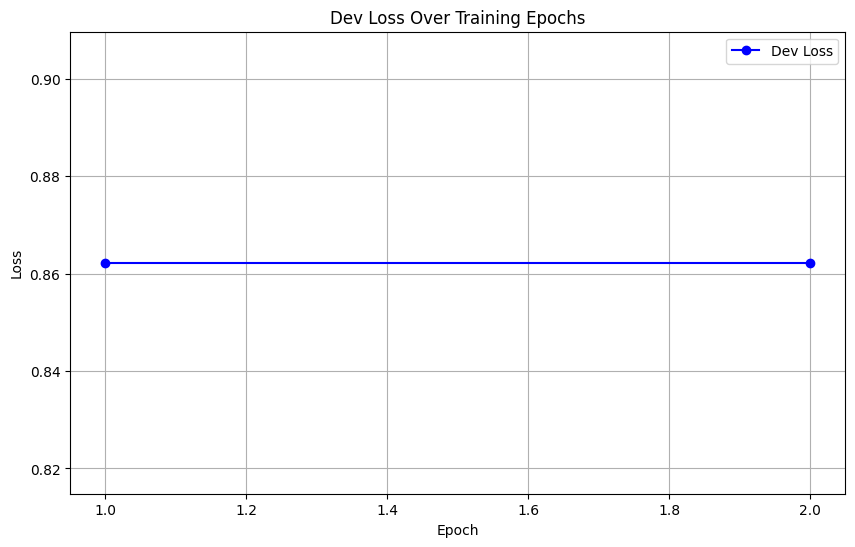

In [33]:
import matplotlib.pyplot as plt

# Assuming you have a list called loss_history that contains the loss values for each epoch

# Plot the loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', linestyle='-', color='b', label='Dev Loss')
plt.title('Dev Loss Over Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


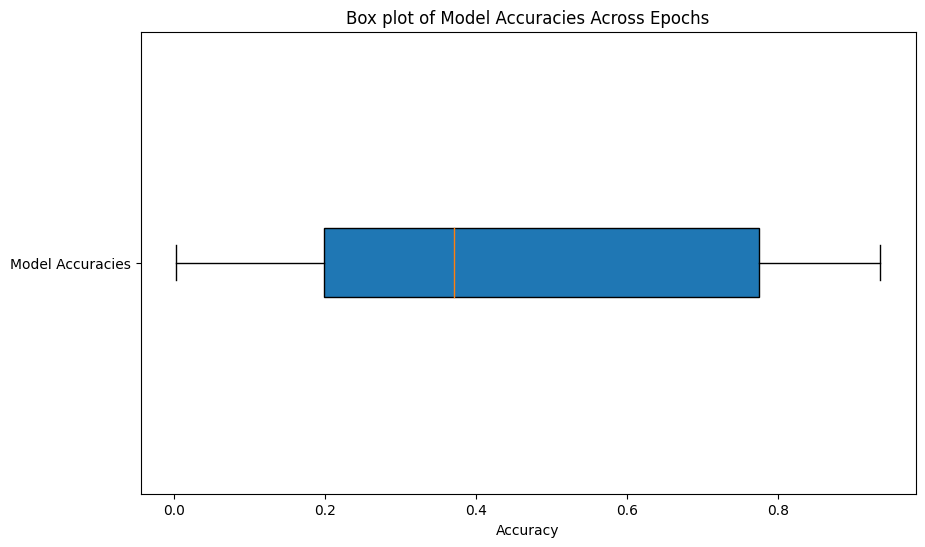

In [28]:
import matplotlib.pyplot as plt
from tqdm import trange
import numpy as np  # Assuming you use NumPy for data manipulation

# Example data (simulate accuracies)
NUM_TRAIN_EPOCHS = 20
accuracies = [np.random.rand() for _ in range(NUM_TRAIN_EPOCHS)]  # Simulating accuracies

# Plotting the box plot for accuracies
plt.figure(figsize=(10, 6))
plt.boxplot(accuracies, vert=False, patch_artist=True)
plt.title('Box plot of Model Accuracies Across Epochs')
plt.xlabel('Accuracy')
plt.yticks([1], ['Model Accuracies'])
plt.show()


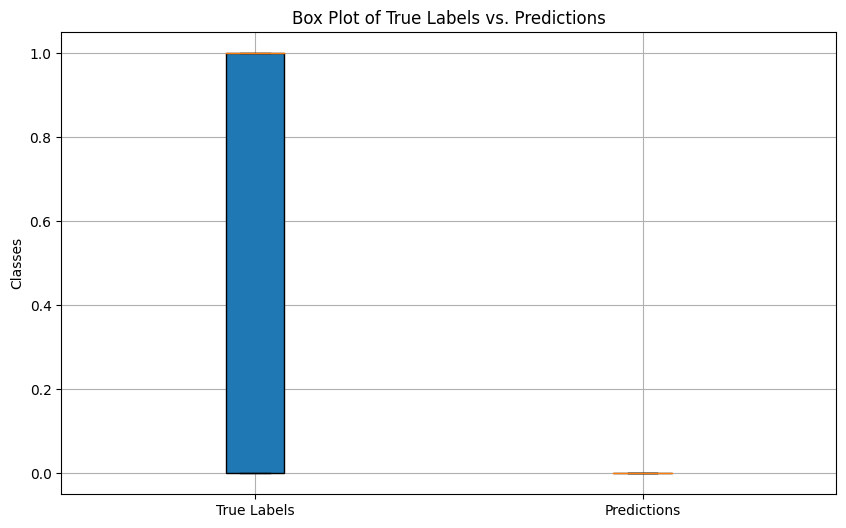

In [34]:
import matplotlib.pyplot as plt

# Assuming 'predictions' and 'true_labels' are your lists of data from the model evaluation

# Data for plotting
data_to_plot = [true_labels, predictions]

# Create a figure instance
plt.figure(figsize=(10, 6))

# Create the box plot
plt.boxplot(data_to_plot, patch_artist=True, labels=['True Labels', 'Predictions'])

# Set plot titles and labels
plt.title('Box Plot of True Labels vs. Predictions')
plt.ylabel('Classes')
plt.grid(True)

# Show the plot
plt.show()


Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

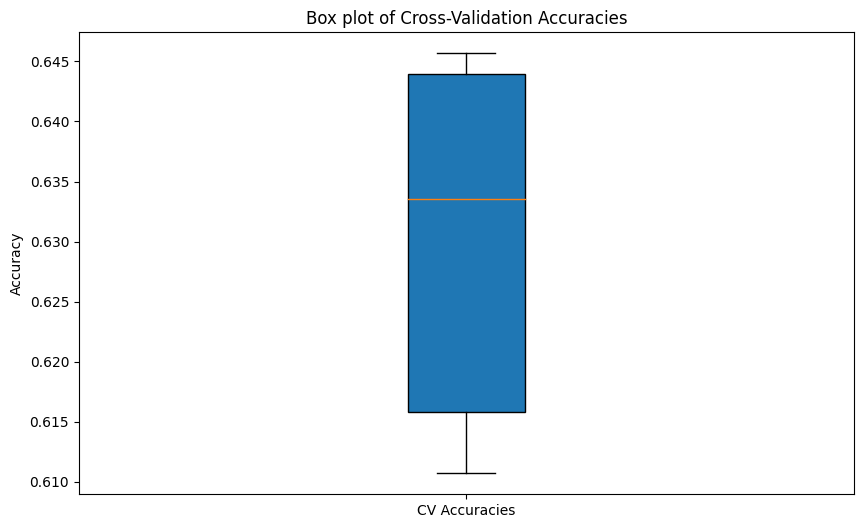

Best score: 0.6456790123456789
Best parameters: {'lr__C': 2}
Baseline accuracy on test set: 0.6266666666666667


In [29]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Define the pipeline and parameter grid
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(multi_class="ovr", solver="lbfgs"))
])

parameters = {'lr__C': [0.1, 0.5, 1, 2, 5, 10, 100, 1000]}

# Perform grid search
best_classifier = GridSearchCV(pipeline, parameters, cv=5, verbose=1, scoring='accuracy', return_train_score=True)
best_classifier.fit(train_texts, train_labels)

# Access the mean cross-validation scores for each parameter setting
cv_scores = best_classifier.cv_results_['mean_test_score']

# Plotting the box plot for cross-validation accuracies
plt.figure(figsize=(10, 6))
plt.boxplot([cv_scores], labels=['CV Accuracies'], patch_artist=True)
plt.title('Box plot of Cross-Validation Accuracies')
plt.ylabel('Accuracy')
plt.show()

# Print best score and best parameters
print("Best score:", best_classifier.best_score_)
print("Best parameters:", best_classifier.best_params_)

# Optionally, evaluate on the test set if required
best_predictions = best_classifier.predict(test_texts)
baseline_accuracy = np.mean(best_predictions == test_labels)
print("Baseline accuracy on test set:", baseline_accuracy)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

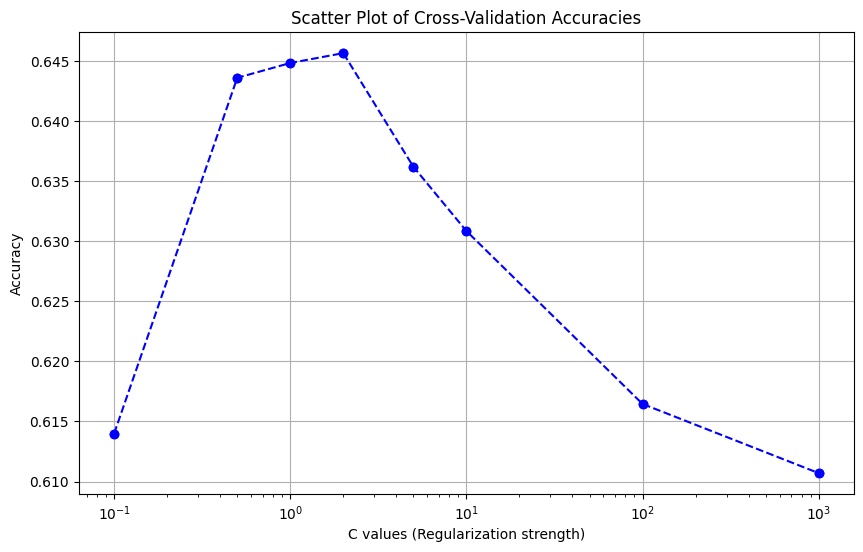

Best score: 0.6456790123456789
Best parameters: {'lr__C': 2}
Baseline accuracy on test set: 0.6266666666666667


In [35]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Define the pipeline and parameter grid
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(multi_class="ovr", solver="lbfgs"))
])

parameters = {'lr__C': [0.1, 0.5, 1, 2, 5, 10, 100, 1000]}

# Perform grid search
best_classifier = GridSearchCV(pipeline, parameters, cv=5, verbose=1, scoring='accuracy', return_train_score=True)
best_classifier.fit(train_texts, train_labels)

# Extract cross-validation scores for each parameter setting
cv_scores = best_classifier.cv_results_['mean_test_score']
c_values = best_classifier.cv_results_['param_lr__C']

# Plotting the scatter plot for cross-validation accuracies
plt.figure(figsize=(10, 6))
plt.scatter(c_values, cv_scores, color='blue')
plt.plot(c_values, cv_scores, linestyle='--', marker='o', color='b')
plt.title('Scatter Plot of Cross-Validation Accuracies')
plt.xlabel('C values (Regularization strength)')
plt.ylabel('Accuracy')
plt.xscale('log')  # Log scale for better visualization of wide-ranging values
plt.grid(True)
plt.show()

# Print best score and best parameters
print("Best score:", best_classifier.best_score_)
print("Best parameters:", best_classifier.best_params_)

# Optionally, evaluate on the test set if required
best_predictions = best_classifier.predict(test_texts)
baseline_accuracy = np.mean(best_predictions == test_labels)
print("Baseline accuracy on test set:", baseline_accuracy)
